# Анализ эффективности рекламных предложений сети кофеен Sturbucks

План работы:

0. Выгрузка и предобработка данных (пустые значения, форматы, дубликаты, выбросы).
1. Общие сведения о клиентах (демография, доход, когда стали клиентом, средний чек, выводы)
2. Анализ эфективности маркетинговых акций 
- анализ акций неинформационного типа: поиск зависимости их показателя конверсии от их параметров
- сравнение акций информационного типа
- сегметация пользователей по полу, возрасту, уровню дохода 
- поиск зависимости показателя конверсии акций неинформационного типа от характеристик клиентов
- выводы
3. Приложение (попытка в кластерный анализ)

Данные:

'offers':
Информация о рекламных предложениях, и основная информация о каждом из них, включая тип рекламной акции, продолжительность рекламной акции, вознаграждение и способ распространения рекламной акции среди клиентов.


'customers':
Данные о каждом человеке, включая его возраст, зарплату и пол.

'transactions':
Записи показывают различные события по рекламным предложениям, полученным клиентом - получение, просмотр и завершение. А также различные транзакции, совершенные человеком с тех пор, как он стал клиентом.


## 0. Выгрузка и предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.patches as mpatches
import scipy
%matplotlib inline

In [2]:
customers = pd.read_csv('C:\\Users\\Михаил\\Desktop\\Data analysis\\Проекты\\Starbucks\\customers.csv', sep=',')
offers = pd.read_csv('C:\\Users\\Михаил\\Desktop\\Data analysis\\Проекты\\Starbucks\\offers.csv', sep=',')
transactions = pd.read_csv('C:\\Users\\Михаил\\Desktop\\Data analysis\\Проекты\\Starbucks\\transactions.csv', sep=',')

In [3]:
customers.head(1)

,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN


In [4]:
offers.head(1)

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


In [5]:
transactions.head(1)

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


Удалим лишние столбцы из данных

In [6]:
customers = customers.drop('Unnamed: 0', 1)
offers = offers.drop('Unnamed: 0', 1)
transactions = transactions.drop('Unnamed: 0', 1)

In [7]:
transactions

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


Поочередно проверим датасеты на наличие пропущенных значений и удалим их

In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
customers[customers.gender.isna() == True].age.value_counts()

118    2175
Name: age, dtype: int64

В customers есть пропущенные значения в столбцах 'gender' и 'income'. В этих строках в столбце 'age' указан возраст 118 лет. Таким образом, данные строки выгружены некорректно. Удалим их из датасета

In [10]:
customers = customers.dropna()

In [11]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [12]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [13]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Приведем в порядок форматы и типы данных в столбцах

Убедимся в том, что в customers в колонке 'became_member_on' находятся даты в некорректном формате - без разделителя

In [14]:
customers.became_member_on = customers.became_member_on.astype(str)

In [15]:
print(sorted(customers.became_member_on.str[0:4].unique()))
print(sorted(customers.became_member_on.str[-4:-2].unique()))
print(sorted(customers.became_member_on.str[-2:].unique()))

['2013', '2014', '2015', '2016', '2017', '2018']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


Действительно, полученные наборы значений соответствуют диапазонам номеров годов, месяцев, дней. Изменим формат на корректный

In [16]:
customers.became_member_on = pd.to_datetime(customers.became_member_on, yearfirst=True)

In [17]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   id                14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


In [18]:
customers.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [19]:
offers = offers.iloc[:, [5,4,3,0,2,1]]

In [20]:
offers

,id,offer_type,duration,reward,difficulty,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,"['email', 'mobile', 'social']"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,"['web', 'email', 'mobile', 'social']"
2,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"['web', 'email', 'mobile']"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"['web', 'email', 'mobile']"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,5,20,"['web', 'email']"
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']"
7,5a8bc65990b245e5a138643cd4eb9837,informational,3,0,0,"['email', 'mobile', 'social']"
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']"
9,2906b810c7d4411798c6938adc9daaa5,discount,7,2,10,"['web', 'email', 'mobile']"


In [21]:
offers.dtypes

id            object
offer_type    object
duration       int64
reward         int64
difficulty     int64
channels      object
dtype: object

In [22]:
transactions.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


В таблице transactions необходимо преобразовать форматы в столбце 'value'. Рассмотрим форматы записей в нем в зависимости от вида события

In [23]:
transactions.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
transactions[transactions.event == 'transaction'].head(3)

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0


In [25]:
transactions[transactions.event == 'offer received'].head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [26]:
transactions[transactions.event == 'offer viewed'].head(3)

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [27]:
transactions[transactions.event == 'offer completed'].head(3)

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0


В колонке 'value' находятся пары ключ-значение. Посмотрим, все ли указанные пары единичны по строкам.

In [28]:
def count_values(a):
    c = 0
    for i in a:
        if i == ":":
            c +=1
    return c

In [29]:
transactions['counting_pairs'] = transactions.value.apply(count_values)

In [30]:
transactions['counting_pairs'].value_counts()

1    272955
2     33579
Name: counting_pairs, dtype: int64

In [31]:
transactions[transactions['counting_pairs'] == 2].head(3)

,person,event,value,time,counting_pairs
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,2


In [32]:
transactions.value[12658]

"{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}"

In [33]:
transactions[transactions.event == 'offer completed'].event.count() == \
transactions[transactions['counting_pairs'] == 2].event.count()

True

В столбце event для событий  transaction, offer received, offer viewed значения представлены в формате {ключ: значение}. В столбце offer completed 2 ключа. Преобразуем данные для более удобной работы, выделив полезную информацию

In [34]:
transactions.value = transactions.value.map(eval)
transactions = pd.concat([transactions.drop(['value'], axis=1), transactions['value'].apply(pd.Series)], axis=1)

In [35]:
transactions.head(3)

,person,event,time,counting_pairs,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,1,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN


In [36]:
transactions[transactions['offer_id'].isna() == False].event.unique()

array(['offer completed'], dtype=object)

In [37]:
transactions[transactions['offer id'].isna() == False].event.unique()

array(['offer received', 'offer viewed'], dtype=object)

In [38]:
transactions[transactions['amount'].isna() == False].event.unique()

array(['transaction'], dtype=object)

In [39]:
transactions.event.count()

306534

In [40]:
transactions[transactions['offer_id'].isna() == False].event.count() + \
transactions[transactions['offer id'].isna() == False].event.count() + \
transactions[transactions['amount'].isna() == False].event.count() == \
transactions.event.count()

True

В записях "offer complited" написание ключа offer_id отличалось от "offer received" и "offer viewed". В записях по платежам ключом было amount. Удалим лишний столбец offer id (без черточки), перенеся значения в единый столбец offer_id (с черточкой).

In [41]:
transactions.loc[transactions['offer_id'].isna() == True, 'offer_id'] = transactions['offer id']

In [42]:
transactions = transactions.drop(columns = ['counting_pairs', 'offer id'])

In [43]:
transactions.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


Разделим датасет transactions на 2 датасета по смыслу:

payments - информация о денежных транзакциях 

offer_events - информация о событиях по акциям

In [44]:
payments = transactions[transactions.event == 'transaction'].drop(columns = ['event', 'offer_id', 'reward'])

In [45]:
offer_events = transactions[transactions.event != 'transaction'].drop(columns = ['amount', 'reward'])

Убедимся в отсутствии аномальных значений в данных по реакциям клиентов на акционные предложения

In [46]:
offer_events.groupby(offer_events.columns.tolist(),as_index=False).size().sort_values('size', ascending=False).head()

,person,event,time,offer_id,size
34200,3526938fb466470190a504a751ec07b0,offer completed,510,0b1e1539f2cc45b7b9fa7c272da2e1d7,3
166313,fea0d1e7c8374feca24c7672e0b60d13,offer completed,450,f19421c1d4aa40978ebb69ca19b0e20d,2
111503,a96c28c4640949ddb38db4c7498f337f,offer completed,624,fafdcd668e3743c1bb461111dcafc2a4,2
49493,4bdd34a262b24807a6f327967aa42ea6,offer completed,444,0b1e1539f2cc45b7b9fa7c272da2e1d7,2
18646,1dc461d98e5c4a5a9b320b78e0ca1efd,offer completed,642,fafdcd668e3743c1bb461111dcafc2a4,2


In [47]:
offer_events.groupby(offer_events.columns.tolist(),as_index=False).size().sort_values('size', ascending=False)\
.query('size > 1').event.value_counts()

offer completed    396
Name: event, dtype: int64

Мы видим, что есть дубликаты по событиям offer_completed. То есть одна и та же акция была использована одним и тем же клиентом в одно и то же время. Учитывая, что данные по времени даны в днях, это вполне возможно.

Однако, логично предположить, что завершенные акционные предложения (offer completed) могут быть тесно связаны с оплатой. Посмотрим, есть ли платежи в один и тот же день в массиве payments:

In [48]:
payments.groupby(['person', 'time'], as_index=False).size().sort_values('size', ascending=False)

,person,time,size
0,0009655768c64bdeb2e877511632db8f,228,1
92630,aa445cee24ba41389eadabcf2fc95bac,624,1
92644,aa4d0ea86b1b4689a0a49a9290b43e85,702,1
92643,aa4d0ea86b1b4689a0a49a9290b43e85,438,1
92642,aa4a681ea192401ab469b616f8fe6885,624,1
...,...,...,...
46313,5504732e8c82404095094982131076d1,360,1
46312,5504732e8c82404095094982131076d1,348,1
46311,5504732e8c82404095094982131076d1,336,1
46310,5504732e8c82404095094982131076d1,270,1


За счет сортировки по убыванию количества убедились, что каждый клиент в определенный час совершал только одну операцию.

Проверим предположение о том, что 

завершение акционного предложения (offer completed) = оплата,

поджойнив завершенные предложения с данными о платежах по id клиента и времени.

In [49]:
payments_for_merge = payments.copy()
payments_for_merge['merge_id'] = payments_for_merge.person + payments_for_merge.time.apply(str)
payments_for_merge.merge_id

12654       02c083884c7d45b39cc68e1314fec56c0
12657       9fa9ae8f57894cc9a3b8a9bbe0fc1b2f0
12659       54890f68699049c2a04d415abc25e7170
12670       b2f1cd155b864803ad8334cdf13c4bd20
12671       fe97aa22dd3e48c8b143116a8403dd520
                         ...                 
306529    b3a1272bc9904337b331bf348c3e8c17714
306530    68213b08d99a4ae1b0dcb72aebd9aa35714
306531    a00058cf10334a308c68e7631c529907714
306532    76ddbd6576844afe811f1a3c0fbb5bec714
306533    c02b10e8752c4d8e9b73f918558531f7714
Name: merge_id, Length: 138953, dtype: object

In [50]:
offer_events_for_merge = offer_events[offer_events.event == 'offer completed'].copy()
offer_events_for_merge['merge_id'] = offer_events_for_merge.person + offer_events_for_merge.time.apply(str)
offer_events_for_merge.merge_id

12658       9fa9ae8f57894cc9a3b8a9bbe0fc1b2f0
12672       fe97aa22dd3e48c8b143116a8403dd520
12679       629fc02d56414d91bca360decdfa92880
12692       676506bad68e4161b9bbaffeb039626b0
12697       8f7dd3b2afe14c078eb4f6e6fe4ba97d0
                         ...                 
306475    0c027f5f34dd4b9eba0a25785c611273714
306497    a6f84f4e976f44508c358cc9aba6d2b3714
306506    b895c57e8cd047a8872ce02aa54759d6714
306509    8431c16f8e1d440880db371a68f82dd0714
306527    24f56b5e1849462093931b164eb803b5714
Name: merge_id, Length: 33579, dtype: object

In [51]:
payments_merged = payments_for_merge.merge(offer_events_for_merge, how='inner', on='merge_id')
payments_merged.head()

,person_x,time_x,amount,merge_id,person_y,event,time_y,offer_id
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5
1,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,fe97aa22dd3e48c8b143116a8403dd520,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4
2,629fc02d56414d91bca360decdfa9288,0,33.90,629fc02d56414d91bca360decdfa92880,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,676506bad68e4161b9bbaffeb039626b,0,18.01,676506bad68e4161b9bbaffeb039626b0,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,19.11,8f7dd3b2afe14c078eb4f6e6fe4ba97d0,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [52]:
print('Общее количество строк в массиве с транзакциями (payments): {}'
      .format(payments.shape[0]))
print('Количество строк по завершенным предложениям в массиве событий по акциям (offer_events): {}'
      .format(offer_events[offer_events.event == 'offer completed'].shape[0]))
print('Количество строк в "пожененном" массиве способом inner join: {}'
      .format(payments_merged.shape[0]))
print('Количество строк в "пожененном" массиве, где id клиента первого равно id клиента второго: {}'
      .format(payments_merged[payments_merged.person_x == payments_merged.person_y].shape[0]))
print('Количество строк в "пожененном" массиве, где время первого равно времени второго: {}'
      .format(payments_merged[payments_merged.time_x == payments_merged.time_y].shape[0]))

Общее количество строк в массиве с транзакциями (payments): 138953
Количество строк по завершенным предложениям в массиве событий по акциям (offer_events): 33579
Количество строк в "пожененном" массиве способом inner join: 33579
Количество строк в "пожененном" массиве, где id клиента первого равно id клиента второго: 33579
Количество строк в "пожененном" массиве, где время первого равно времени второго: 33579


Таким образом, мы убедились, что данные по завершенным акциям полностью входят в массив с платежами (остальные платежи не относятся к рассматриваемым акциям). При этом в массиве payments каждая пара клиент-время платежа уникальна, а в массиве offer_events есть завершенные акции, использованные одним клиентом в одно и то же время.

Этому может быть только 2 объяснения:

1) не все транзакции отражены в массиве платежей;

2) в массиве событий по акциям есть дубликаты записей offer complited.

В отсутствие других данных для сверки платежей, на основании здравого смысла примем, что причой несоответствия являются дубликаты в событиях. Удалим их:

In [53]:
offer_events.shape[0]

167581

In [54]:
offer_events = offer_events.drop_duplicates()

In [55]:
offer_events.shape[0]

167184

Далее рассмотрим распределение операций всех клиентов по времени.

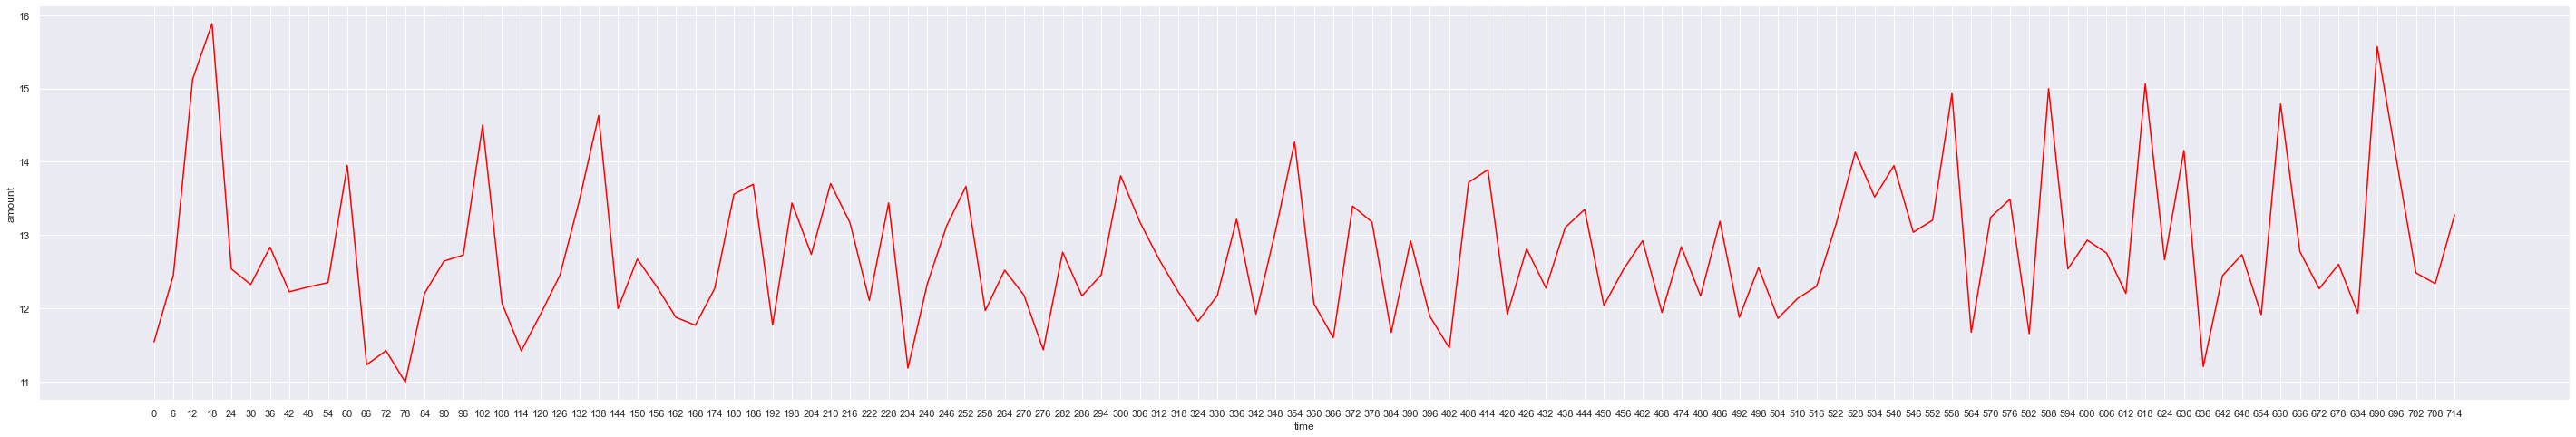

In [56]:
plt.figure(figsize = (50,8))
sns.set_theme(palette='pastel')
ax = sns.lineplot(data = payments, x = 'time', y = 'amount', ci=None, color='red')
plt.xticks(payments['time'].unique())
plt.show()

Явные аномалии также не выявлены.

Рассмотрим распределение по суммам платежей:

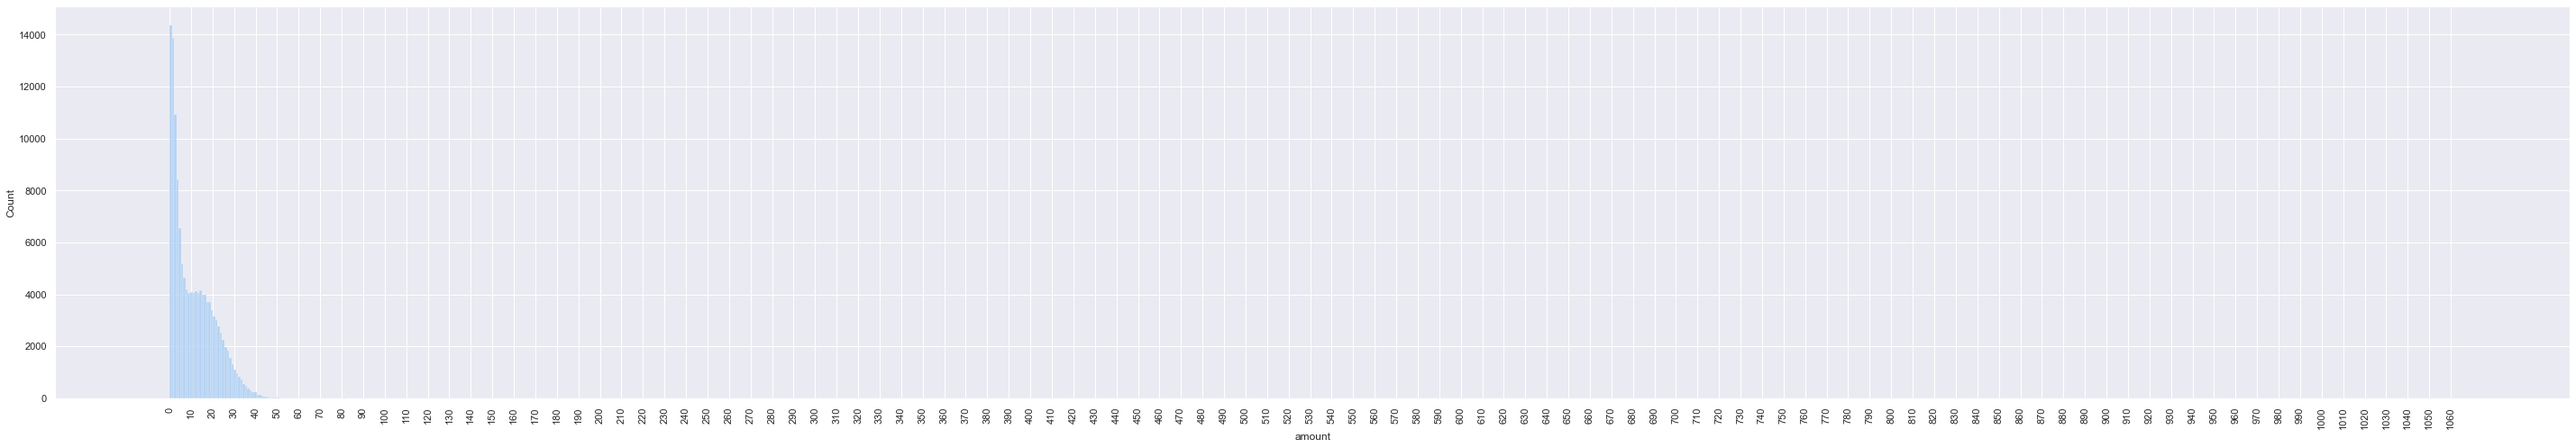

In [57]:
plt.figure(figsize=(50,8))
sns.histplot(payments['amount'], bins = 1000)
plt.xticks(range(0, int(payments['amount'].max()), 10), rotation=90)
plt.show()

На графике есть выбросы справа.

Рассмотрим распределение выбросов по суммам платежей отдельно:

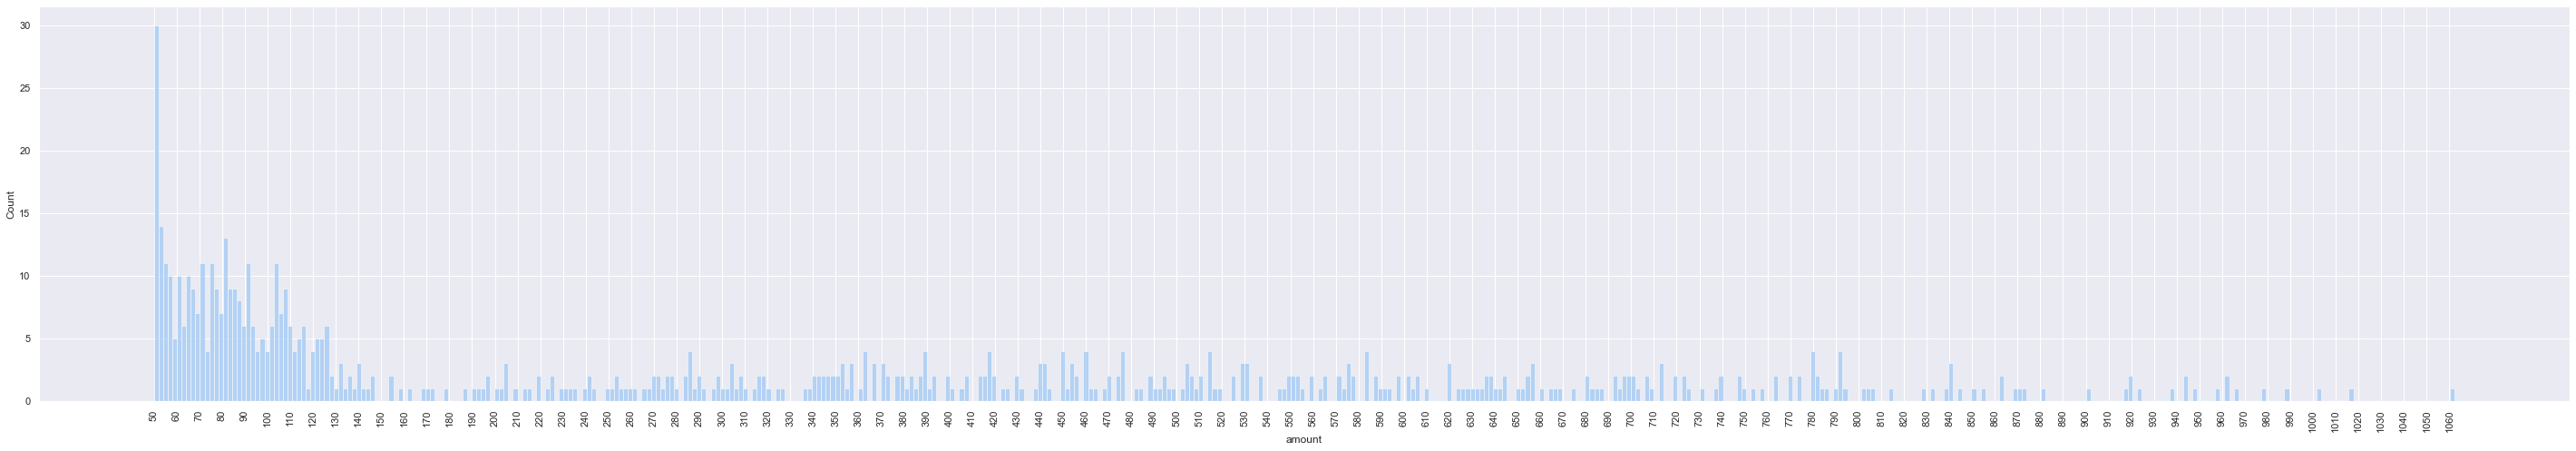

In [58]:
plt.figure(figsize=(50,8))
ax = sns.histplot(payments[payments.amount > 50].amount, bins = 500)
plt.xticks(range(50, int(payments['amount'].max()), 10), rotation=90)
plt.show()

Явные аномалии отсутствуют. Высокие показатели частотности слева обусловлены близостью к основной группе.

Рассмотрим абсолютные и относительные показатели аномально высоких платежей, в том числе, по клиентам.

In [59]:
payments[payments.amount > 50].person.nunique()

687

In [60]:
print('Количество аномально высоких платежей: {}'
      .format(payments[payments.amount > 50].amount.count(), 1))
print('Общее количество платежей: {}'
      .format(payments.amount.count(), 1))
print('Доля аномально высоких платежей, относительно всех платежей по количеству: {} %'
      .format(round(payments[payments.amount > 50].amount.count() * 100 / payments.amount.count(), 1)), end='\n\n')
print('Сумма аномально высоких платежей: {}'
      .format(round(payments[payments.amount > 50].amount.sum(), 2)))
print('Общая сумма платежей: {}'
      .format(round(payments.amount.sum(), 2)))
print('Доля аномально высоких платежей, относительно всех платежей по сумме: {} %'
      .format(round(payments[payments.amount > 50].amount.sum() * 100 / payments.amount.sum(), 1)), end='\n\n')
print('Общее количество уникальных клиентов: {}'
      .format(payments.person.nunique()))
print('Количество уникальных клиентов, совершивших аномально высокие платежи: {},'
      .format(payments[payments.amount > 50].person.nunique()))
print('из них совершивших аномально высокий платеж \n- 1 раз: {} ({}%),'
      .format((payments[payments.amount > 50].groupby('person', as_index=False).agg({'amount':'count'}) == 1)
              .amount.sum(), round((payments[payments.amount > 50].groupby('person', as_index=False).agg({'amount':'count'}) == 1)
              .amount.sum() * 100 / payments[payments.amount > 50].person.nunique(), 1)))
print('- 2 раза: остальные {} ({}%).'
      .format((payments[payments.amount > 50].groupby('person', as_index=False).agg({'amount':'count'}) == 2)
              .amount.sum(), round((payments[payments.amount > 50].groupby('person', as_index=False).agg({'amount':'count'}) == 2)
              .amount.sum() * 100 / payments[payments.amount > 50].person.nunique(), 1)))
print('Доля уникальных клиентов, совершивших аномально высокие платежи, относительно всех уникальных клиентов: {} %'
      .format(round(payments[payments.amount > 50].person.nunique() * 100 / payments.person.nunique(), 1)))

Количество аномально высоких платежей: 706
Общее количество платежей: 138953
Доля аномально высоких платежей, относительно всех платежей по количеству: 0.5 %

Сумма аномально высоких платежей: 223804.64
Общая сумма платежей: 1775451.97
Доля аномально высоких платежей, относительно всех платежей по сумме: 12.6 %

Общее количество уникальных клиентов: 16578
Количество уникальных клиентов, совершивших аномально высокие платежи: 687,
из них совершивших аномально высокий платеж 
- 1 раз: 668 (97.2%),
- 2 раза: остальные 19 (2.8%).
Доля уникальных клиентов, совершивших аномально высокие платежи, относительно всех уникальных клиентов: 4.1 %


Данные о закупаемых именованиях, валюте платежей и прайсе отсутствуют, поэтому отсутствует возможность оценить данные платежи с точки зрения потребительской логики.

Тем не менее, с учетом проведенного анализа аномалий, риск того, что полученные выбросы - ошибки выгрузки, минимален. Следовательно, это действительно большие заказы, возможно в рамках праздников, корпоративов или других мероприятий, оплаченные по картам конкретных клиентов.

Главный вопрос - стоит ли включать подобные заказы в расчет среднего чека и в анализ реакций клиентов на акции?

Ответ - в зависимости от логики расчета каждого конкретного показателя. Таким образом, решение о необходимости исключения выбросов по платежам из расчетов будет обосновано отдельно в ходе дальнейшего анализа.

В результате предобработки данных получилось 4 таблицы:

1. Сведения о параметрах акций (offers):

In [61]:
offers.head(3)

,id,offer_type,duration,reward,difficulty,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,"['email', 'mobile', 'social']"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,"['web', 'email', 'mobile', 'social']"
2,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"['web', 'email', 'mobile']"


2. Сведения о клиентах (customers):

In [62]:
customers.head(3)

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0


3. Данные по реакциям клиентов на акционные предложения (offer_events):

In [63]:
offer_events.head(3)

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5


4. Данные по совершенным платежам (payments):

In [64]:
payments.head(3)

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23


## 1. Общие сведения по клиентам

Рассчитаем средний чек по данным платежей. 

Разделим платежи на 2 группы - стандартные (<=50 у.е.) и крупные (>50 у.е.) заказы, на основании формы распределения. Далее рассчитаем средний чек по стандартным заказам, крупным и по всем заказам вместе.

In [65]:
print('Средний чек по стандартным заказам: {} у.е.'.format(round(payments[payments.amount <= 50].amount.mean(), 2)))
print('Средний чек по крупным заказам: {} у.е.'.format(round(payments[payments.amount > 50].amount.mean(), 2)))
print('Средний чек по всем заказам: {} у.е. (+{}% к станд.)'.format(round(payments.amount.mean(), 2), 
                                                          round(100 * (payments.amount.mean() - 
                                                          payments[payments.amount <= 50].amount.mean()) /
                                                          payments[payments.amount <= 50].amount.mean(), 1)))

Средний чек по стандартным заказам: 11.22 у.е.
Средний чек по крупным заказам: 317.0 у.е.
Средний чек по всем заказам: 12.78 у.е. (+13.8% к станд.)


Несмотря на солидную величину среднего чека по крупным заказам, величина среднего чека по всем заказам приросла не очень драматично из-за их малого количества.

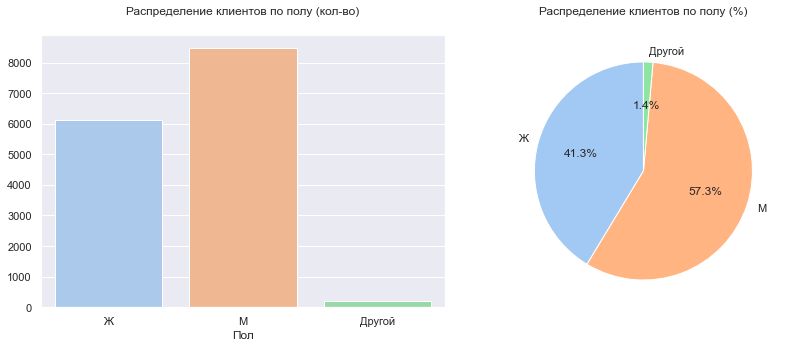

In [66]:
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
ax = sns.countplot(data = customers, x = 'gender')
plt.title('Распределение клиентов по полу (кол-во)', fontsize = 12, pad = 20)
ax.set_xticklabels(['Ж', 'М', 'Другой'])
plt.xlabel('Пол', fontsize = 12)
plt.ylabel('')

plt.subplot(1, 2, 2)
plt.pie([
    round(customers.gender.value_counts(normalize=True).mul(100), 1)['F'],
    round(customers.gender.value_counts(normalize=True).mul(100), 1)['M'],
    round(customers.gender.value_counts(normalize=True).mul(100), 1)['O']], 
        labels=['Ж', 'М', 'Другой'], autopct='%1.1f%%',
        shadow=False, startangle=90)
plt.title('Распределение клиентов по полу (%)', fontsize = 12, pad = 20)

plt.tight_layout()

Как видно из представленных данных большую часть посетителей составляют представители мужской половины населения (57.23%). Немаловажным фактом является наличие среди клиентов небинарных личностей - вариант Другое указали 1.43 % посетителей.

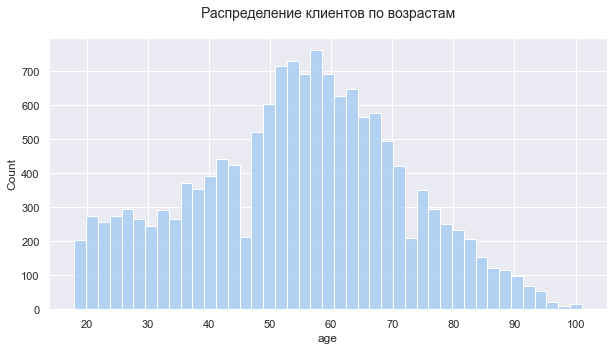

In [67]:
plt.figure(figsize = (10, 5))
ax = sns.histplot(x = customers.age)
ax.set_title('Распределение клиентов по возрастам', fontsize = 14, pad = 20)
plt.locator_params(axis='x', nbins=10)

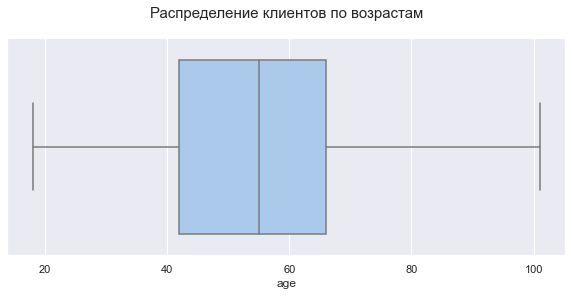

In [68]:
plt.figure(figsize = (10, 4))
ax = sns.boxplot(x = customers.age)
ax.set_title('Распределение клиентов по возрастам', fontsize = 15, pad = 20)
plt.show()

In [177]:
round(customers.age.quantile([0, 0.25, 0.5, 0.75, 1]), 1)

0.00     18.0
0.25     42.0
0.50     55.0
0.75     66.0
1.00    101.0
Name: age, dtype: float64

In [178]:
round(customers.age.apply(['mean', 'median']), 1)

mean      54.4
median    55.0
Name: age, dtype: float64

Минимальный возраст клиента составляет 18 лет, максимальный - 101(!) год. 

Средний возраст клиентов составляет 54.4 года.

Значительную часть клиентов составляют люди зрелого возраста от 42 до 66 лет (50%).

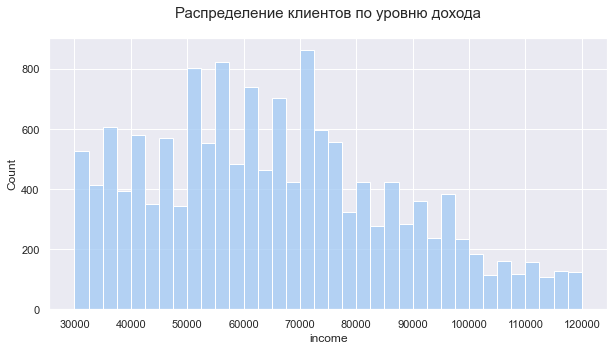

In [69]:
plt.figure(figsize = (10, 5))
ax = sns.histplot(x = customers.income)
ax.set_title('Распределение клиентов по уровню дохода', fontsize = 15, pad = 20)
plt.locator_params(axis='x', nbins=10)

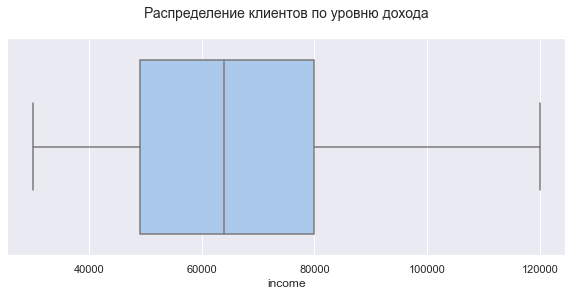

In [70]:
plt.figure(figsize = (10, 4))
ax = sns.boxplot(x = customers.income)
ax.set_title('Распределение клиентов по уровню дохода', fontsize = 14, pad = 20)
plt.show()

In [173]:
round(customers.income.quantile([0, 0.25, 0.5, 0.75, 1]), 2)

0.00     30000.0
0.25     49000.0
0.50     64000.0
0.75     80000.0
1.00    120000.0
Name: income, dtype: float64

In [181]:
round(customers.income.apply(['mean', 'median']), 1)

mean      65405.0
median    64000.0
Name: income, dtype: float64

Минимальный доход клиента составляет 30 тыс. у.е., максимальный - 120 тыс. у.е. 

Средний доход клиентов составляет 65,4 тыс. у.е. 

Значительную часть клиентов составляют люди с доходом от 49 тыс. до 80 тыс. у.е. (50%)

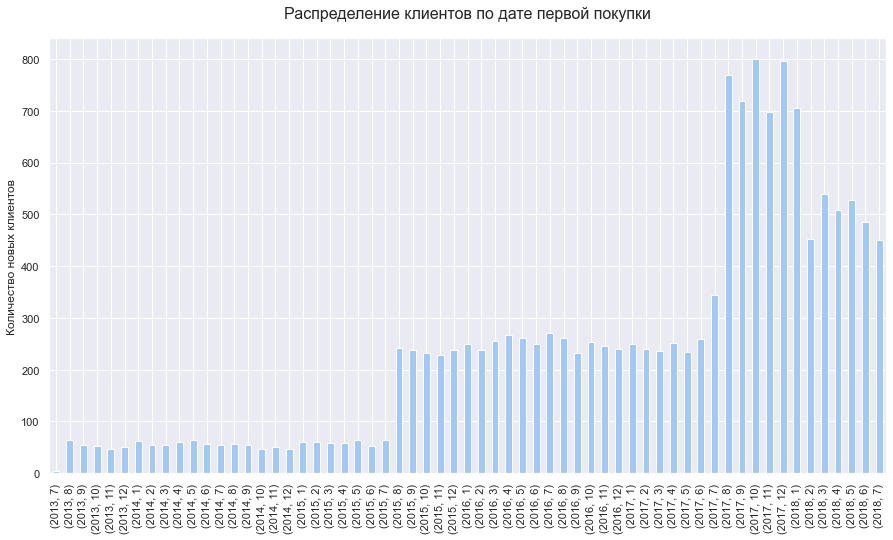

In [71]:
plt.figure(figsize = (15, 8))
ax = customers.groupby([customers.became_member_on.dt.year, customers.became_member_on.dt.month])\
.became_member_on.count().plot(kind='bar')
ax.set_title('Распределение клиентов по дате первой покупки', fontsize = 16, pad = 20)
plt.xlabel('')
plt.ylabel('Количество новых клиентов')
plt.show()

На графике видно, что клиенты приходили в несколько "волн", причем скорость прироста изменялась от волны к волне. 

Можно выделить 4 периода с различными показателями прироста клиентов:
1. июль 2013 - июль 2015
2. август 2015 - июль 2017
3. август 2017 - январь 2018
4. февраль 2018 - июль 2018

Посмотрим, в какой день недели приток новых клиентов был максимальным

In [72]:
customers['bmo_weekday'] = customers.became_member_on.dt.day_name()

Text(0, 0.5, 'Количество новых клиентов')

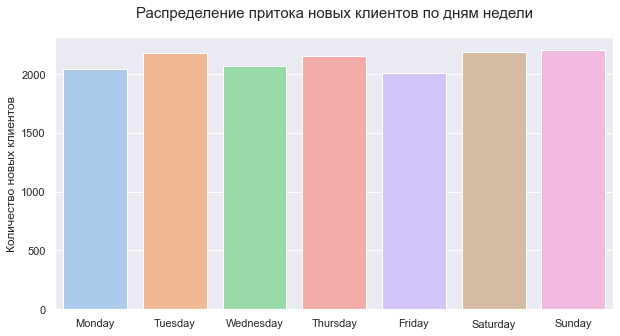

In [172]:
plt.figure(figsize = (10, 5))
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax = sns.countplot(data=customers, x = 'bmo_weekday', order = order)
ax.set_title('Распределение притока новых клиентов по дням недели', fontsize = 15, pad = 20)
plt.xlabel('')
plt.ylabel('Количество новых клиентов')

На основании представленных данных можно сделать вывод о преимущественно равномерном распределении регистраций новых клиентов по дням недели. Есть небольшое повышение показателей регистрации в выходные дни, но оно относительно несущественно.

## Выводы на основании информации о клиентах

Выводы:

Большую часть посетителей составляют представители мужской половины населения (57.23%). 

Немаловажным фактом является наличие среди клиентов небинарных личностей (1.43 %).

Минимальный возраст клиента составляет 18 лет, максимальный - 101(!) год. 

Средний возраст клиентов составляет 54.4 года.

Значительную часть клиентов составляют люди зрелого возраста от 42 до 66 лет (50%).

Минимальный доход клиента составляет 30 тыс. у.е., максимальный - 120 тыс. у.е. 

Средний доход клиента составляет 65.4 тыс. у.е. 

Значительную часть клиентов составляют люди с доходом от 49 тыс. до 80 тыс. у.е. (50%)

Средний чек по стандартным заказам: 11.22 у.е.

Средний чек по крупным заказам: 317.0 у.е.

Средний чек по всем заказам: 12.78 у.е. (+13.8% к станд.)


# 2. Анализ эффективности акционных предложений

Проанализируем данные по реакциям клиентов на рекламные предложения 

In [77]:
offer_events.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33182
Name: event, dtype: int64

Рассмотрим соотношения полученных, просмотренных и завершенных предложений по рекламным акциям

In [78]:
offer_events_piv = offer_events.pivot_table(index = 'offer_id', columns = 'event', values = 'person', aggfunc='count')\
.reset_index()
offer_events_piv = offer_events_piv[['offer_id', 'offer received', 'offer viewed', 'offer completed']]
offer_events_piv

event,offer_id,offer received,offer viewed,offer completed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668.0,2663.0,3340.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646.0,7337.0,5112.0
2,2906b810c7d4411798c6938adc9daaa5,7632.0,4118.0,3964.0
3,3f207df678b143eea3cee63160fa8bed,7617.0,4144.0,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593.0,7298.0,3301.0
5,5a8bc65990b245e5a138643cd4eb9837,7618.0,6687.0,NaN
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677.0,4171.0,4303.0
7,ae264e3637204a6fb9bb56bc8210ddfd,7658.0,6716.0,3635.0
8,f19421c1d4aa40978ebb69ca19b0e20d,7571.0,7264.0,4262.0
9,fafdcd668e3743c1bb461111dcafc2a4,7597.0,7327.0,5265.0


По двум рекламным акциям отсутствуют сведения о завершенных предложениях

In [79]:
offers_no_complete = list(offer_events_piv[offer_events_piv.isna().any(1)].offer_id.unique())
offers_no_complete

['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']

Проверим на логику соотношения событий

In [80]:
n1 = offer_events_piv[offer_events_piv['offer viewed'] > offer_events_piv['offer received']].offer_id.unique()
if len(n1) != 0:
    print('Рекламные акции, по которым сумма просмотренных предложений превышает сумму полученных \
    предложений: {}'.format(n1))
else: print('Рекламные акции, по которым сумма просмотренных предложений превышает сумму полученных предложений, \
отсутствуют.')

Рекламные акции, по которым сумма просмотренных предложений превышает сумму полученных предложений, отсутствуют.


In [81]:
n2 = offer_events_piv[offer_events_piv['offer completed'] > offer_events_piv['offer received']].offer_id.unique()
if len(n2) != 0:
    print('Рекламные акции, по которым сумма завершенных предложений превышает сумму полученных \
    предложений: {}'.format(n2))
else: print('Рекламные акции, по которым сумма завершенных предложений превышает сумму полученных предложений, \
отсутствуют.')

Рекламные акции, по которым сумма завершенных предложений превышает сумму полученных предложений, отсутствуют.


In [82]:
n3 = list(offer_events_piv[offer_events_piv['offer completed'] > offer_events_piv['offer viewed']].offer_id.unique())
if len(n3) != 0:
    print('Рекламные акции, по которым сумма завершенных предложений превышает сумму просмотренных предложений:\n {}'
          .format(n3))
else: print('Рекламные акции, по которым сумма завершенных предложений превышает сумму полученных предложений, \
отсутствуют.')

Рекламные акции, по которым сумма завершенных предложений превышает сумму просмотренных предложений:
 ['0b1e1539f2cc45b7b9fa7c272da2e1d7', '9b98b8c7a33c4b65b9aebfe6a799e6d9']


In [83]:
offers_strange = n3
offers_strange

['0b1e1539f2cc45b7b9fa7c272da2e1d7', '9b98b8c7a33c4b65b9aebfe6a799e6d9']

In [84]:
offers_no_complete

['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']

Как видно из представленных данных по двум рекламным акциям нет данных о завершенных рекламных предложениях, также по двум другим рекламным акциям количество завершенных рекламных предложений превышает количество просмотренных. Попробуем выяснить причины данных логических несоответствий

In [85]:
offers.style.apply(lambda x: ['background:orange' if x in offers_no_complete 
                              else 'background:white' for x in offers.id])

,id,offer_type,duration,reward,difficulty,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,"['email', 'mobile', 'social']"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,"['web', 'email', 'mobile', 'social']"
2,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"['web', 'email', 'mobile']"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"['web', 'email', 'mobile']"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,5,20,"['web', 'email']"
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']"
7,5a8bc65990b245e5a138643cd4eb9837,informational,3,0,0,"['email', 'mobile', 'social']"
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']"
9,2906b810c7d4411798c6938adc9daaa5,discount,7,2,10,"['web', 'email', 'mobile']"


Легко заметить, что завершенные предложения отсутствуют по акциям информационного типа, что логично.

Локализуем превышение завершенных предложений над просмотренными

In [86]:
offers.style.apply(lambda x: ['background:yellow' if x in offers_strange 
                              else 'background:white' for x in offers.id])

,id,offer_type,duration,reward,difficulty,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,"['email', 'mobile', 'social']"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,"['web', 'email', 'mobile', 'social']"
2,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"['web', 'email', 'mobile']"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"['web', 'email', 'mobile']"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,5,20,"['web', 'email']"
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']"
7,5a8bc65990b245e5a138643cd4eb9837,informational,3,0,0,"['email', 'mobile', 'social']"
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']"
9,2906b810c7d4411798c6938adc9daaa5,discount,7,2,10,"['web', 'email', 'mobile']"


In [87]:
offer_events_piv.style.apply(lambda x: ['background:yellow' if x in offers_strange 
                              else 'background:white' for x in offer_events_piv.offer_id])

event,offer_id,offer received,offer viewed,offer completed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668.000000,2663.000000,3340.000000
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646.000000,7337.000000,5112.000000
2,2906b810c7d4411798c6938adc9daaa5,7632.000000,4118.000000,3964.000000
3,3f207df678b143eea3cee63160fa8bed,7617.000000,4144.000000,nan
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593.000000,7298.000000,3301.000000
5,5a8bc65990b245e5a138643cd4eb9837,7618.000000,6687.000000,nan
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677.000000,4171.000000,4303.000000
7,ae264e3637204a6fb9bb56bc8210ddfd,7658.000000,6716.000000,3635.000000
8,f19421c1d4aa40978ebb69ca19b0e20d,7571.000000,7264.000000,4262.000000
9,fafdcd668e3743c1bb461111dcafc2a4,7597.000000,7327.000000,5265.000000


Выделенны рекламные акции, количество завершенных рекламных предложений по которым превышает количество просмотренных. Указанные рекламные акции не имеют специфических общих черт.

Рассмотрим распределение событий по времени

In [88]:
offer_events_piv2 = offer_events.pivot_table(index = 'time', columns = 'event', values = 'offer_id', 
                                             aggfunc='count').reset_index().iloc[:, [0,2,3,1]]
offer_events_piv2.head()

event,time,offer received,offer viewed,offer completed
0,0,12650.0,2072.0,206.0
1,6,NaN,1433.0,276.0
2,12,NaN,1085.0,280.0
3,18,NaN,884.0,252.0
4,24,NaN,734.0,265.0


In [89]:
pd.DataFrame(offer_events_piv2.count()).transpose()

event,time,offer received,offer viewed,offer completed
0,120,6,120,120


In [90]:
round(offer_events[offer_events.event == 'offer received'].time.value_counts(normalize = True), 2)

408    0.17
576    0.17
336    0.17
504    0.17
168    0.17
0      0.17
Name: time, dtype: float64

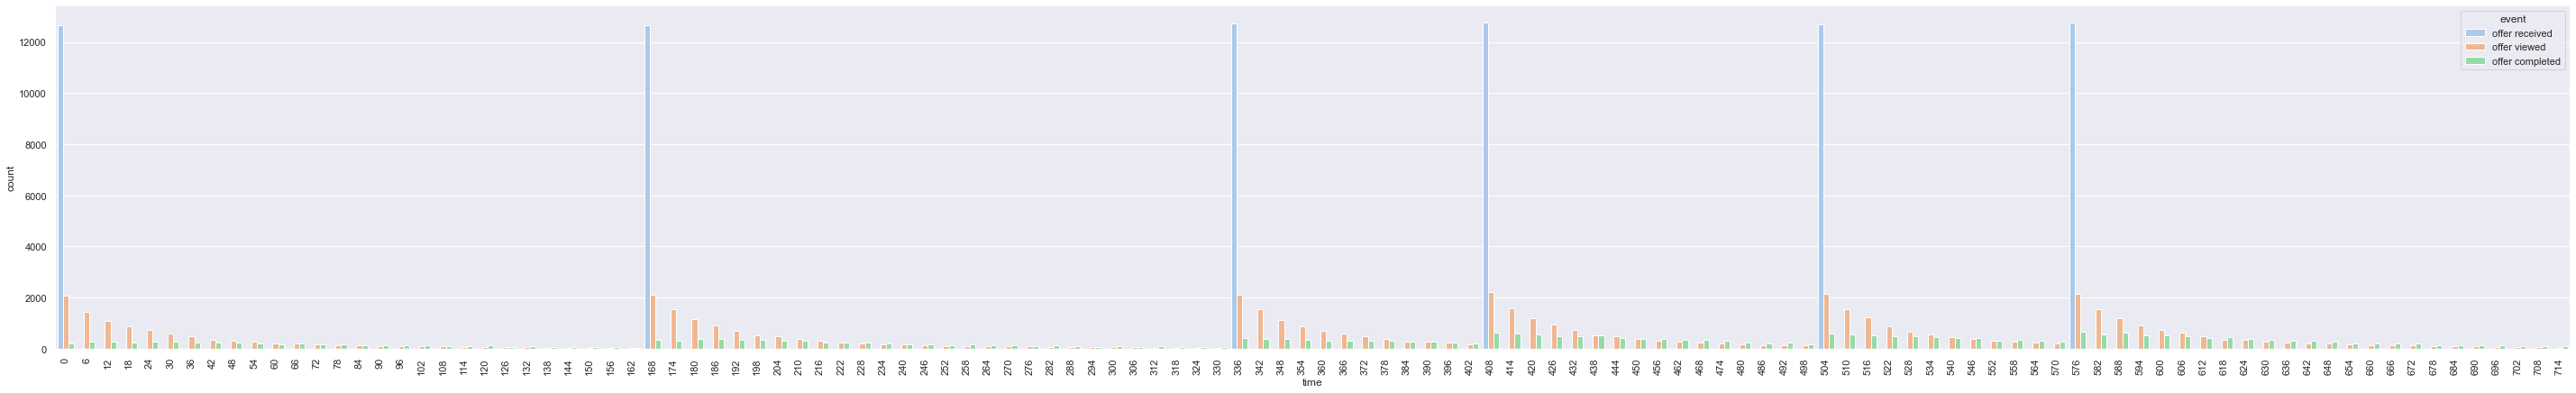

In [91]:
plt.figure(figsize = (50, 7))
sns.countplot(data = offer_events, x = 'time', hue = 'event')
plt.xticks(rotation = 90)

plt.show()

В распределении событий по времени не обнаружено аномалий среди просмотренных и завершенных предложений. Данные о полученных предложениях свидетельствуют о периодичности их отправки, что также не вызывает подозрений.

Рассмотрим статистику по событиям в разрезе клиентов и акций

In [92]:
offer_events_count = offer_events.pivot_table(index = ['person', 'offer_id'], 
                         columns = 'event', values = 'time', aggfunc = 'count')\
.reset_index().iloc[:, [0,1,3,4,2]]
offer_events_count.head()

event,person,offer_id,offer received,offer viewed,offer completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,NaN,1.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,1.0,NaN
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,NaN
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0


Далее отберем только те уникальные пары клиент-акция, для которых выполняется условие превышения количества завершенных предложений над количеством просмотренных. Рассчитаем количество уникальных акций в отобранных строках, таким образом увидим, сколько акций, по которым есть указанное превышение хотя бы по одному клиенту 

In [93]:
print('Количество рекламных акций, по которым наблюдается превышение завершенных акционных предложений над просмотренными хотя бы по одному клиенту: {}'
      .format(offer_events_count.query('`offer viewed` < `offer completed`').offer_id.nunique()))

Количество рекламных акций, по которым наблюдается превышение завершенных акционных предложений над просмотренными хотя бы по одному клиенту: 8


Таким образом, по рекламным акциям информационного типа сведения о завершении отсутствуют.

По двум акциям неинформационного типа установлено превышение количества завершенных рекламных компаний над количествм просмотренных. Кроме того, по итогам подсчета количества различных действий по уникальным парам клиент-акция выявлено, что аналогичная ситуация превышения завершенных акционных предложений над просмотренными встречается и среди отдельных клиентов по 6 остальным рекламным акциям неинформационного типа.Следовательно, просмотр не является обязательным условием для завершения поступившего предложения. Поэтому учет данного события в общей воронке целевых действий нецелесообразен. Далее будет произведен расчет общей эффективности рекламных акций неинформационного типа на основании соотношения полученных (отправленных) акционных предложений и использованных (завершенных).

После будет расчитана эффективность информационных акций на основе соотношения полученных и просмотренных акционных предложений. Стоит отметить, главное различие двух информационных акций - в использованных каналах коммуникации. Таким образом, данный анализ поможет оценить эффективность соответствующих каналов.

In [94]:
offers_report = offers.merge(offer_events_piv, how='left', left_on='id', right_on='offer_id')\
.drop(columns=['offer viewed', 'offer_id'])
offers_report['%'] = round(offers_report['offer completed'] * 100 / offers_report['offer received'], 1)
offers_report = offers_report[offers_report['offer completed'].isna() == False].sort_values('%', ascending = False)\
.reset_index(drop=True)
offers_report

,id,offer_type,duration,reward,difficulty,channels,offer received,offer completed,%
0,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']",7597.0,5265.0,69.3
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']",7646.0,5112.0,66.9
2,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",7571.0,4262.0,56.3
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"['web', 'email', 'mobile']",7677.0,4303.0,56.1
4,2906b810c7d4411798c6938adc9daaa5,discount,7,2,10,"['web', 'email', 'mobile']",7632.0,3964.0,51.9
5,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,"['email', 'mobile', 'social']",7658.0,3635.0,47.5
6,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,5,20,"['web', 'email']",7668.0,3340.0,43.6
7,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,"['web', 'email', 'mobile', 'social']",7593.0,3301.0,43.5


In [95]:
offers_medimeans = pd.DataFrame([round(offers_report[['duration', 'reward', 'difficulty', '%']].mean(), 1),
                                 round(offers_report[['duration', 'reward', 'difficulty', '%']].median(), 1)], 
                                 index = ['mean', 'median'])
print('Средние и медианные показатели по параметрам акций')
offers_medimeans

Средние и медианные показатели по параметрам акций


,duration,reward,difficulty,%
mean,7.2,5.2,9.6,54.4
median,7.0,5.0,10.0,54.0


По основному показателю вовлеченности - отношению использованных акционных предложений к полученным (среди всех пользователей) - лидирует акция (id 'fafdcd668e3743c1bb461111dcafc2a4') типа discount с показателем 69.3 %. 
Стоит отметить, указанная акция обладает максимальным из представленных показателем продолжительности - 10 и, при этом, минимальным из представленных показателем вознаграждения - 2 (размер минимальных затрат для участия в акции - difficulty - средний).
Также заметим, что первые два места по показателю вовлеченности занимают акции типа дисконт, с существенным отрывом от идущей на 3 месте акции типа bogo. Необходимо проверить, действительно ли акции типа дисконт успешнее вовлекают клиентов на выбранном массиве.

Предобработаем данные для проведения всех возможных видов анализа в дальнейшем

In [96]:
offers

,id,offer_type,duration,reward,difficulty,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,"['email', 'mobile', 'social']"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,"['web', 'email', 'mobile', 'social']"
2,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"['web', 'email', 'mobile']"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"['web', 'email', 'mobile']"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,5,20,"['web', 'email']"
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']"
7,5a8bc65990b245e5a138643cd4eb9837,informational,3,0,0,"['email', 'mobile', 'social']"
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']"
9,2906b810c7d4411798c6938adc9daaa5,discount,7,2,10,"['web', 'email', 'mobile']"


In [97]:
offers['email'] = offers['channels'].str.contains('email').apply(int)
offers['web'] = offers['channels'].str.contains('web').apply(int)
offers['mobile'] = offers['channels'].str.contains('mobile').apply(int)
offers['social'] = offers['channels'].str.contains('social').apply(int)

In [98]:
offers

,id,offer_type,duration,reward,difficulty,channels,email,web,mobile,social
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,"['email', 'mobile', 'social']",1,0,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,"['web', 'email', 'mobile', 'social']",1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"['web', 'email', 'mobile']",1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"['web', 'email', 'mobile']",1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,5,20,"['web', 'email']",1,1,0,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']",1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']",1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,informational,3,0,0,"['email', 'mobile', 'social']",1,0,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,discount,7,2,10,"['web', 'email', 'mobile']",1,1,1,0


In [99]:
offer_events_full = offer_events_count.copy()
offer_events_full = offer_events_full.merge(offers, how='left', left_on='offer_id', right_on='id').drop(columns='id')

In [100]:
offer_events_full.isna().sum()

person                 0
offer_id               0
offer received         0
offer viewed       14153
offer completed    34292
offer_type             0
duration               0
reward                 0
difficulty             0
channels               0
email                  0
web                    0
mobile                 0
social                 0
dtype: int64

In [101]:
offer_events_full = offer_events_full.fillna(0)

In [102]:
offer_events_full.isna().sum()

person             0
offer_id           0
offer received     0
offer viewed       0
offer completed    0
offer_type         0
duration           0
reward             0
difficulty         0
channels           0
email              0
web                0
mobile             0
social             0
dtype: int64

In [103]:
offer_events_full[['offer received', 'offer viewed',
       'offer completed']] = offer_events_full[['offer received', 'offer viewed',
       'offer completed']].astype(int)

Выделим для отдельного анализа данные по акциям информационного типа

In [104]:
offer_events_inf = offer_events_full[offer_events_full.offer_type == 'informational']
offer_events_full = offer_events_full[offer_events_full.offer_type != 'informational']

Получим массив следующего вида:

In [105]:
offer_events_full.head(5)

,person,offer_id,offer received,offer viewed,offer completed,offer_type,duration,reward,difficulty,channels,email,web,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,discount,7,2,10,"['web', 'email', 'mobile']",1,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,discount,10,2,10,"['web', 'email', 'mobile', 'social']",1,1,1,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,2,2,0,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",1,1,1,1
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,discount,10,5,20,"['web', 'email']",1,1,0,0


In [106]:
print('Среднее количество уникальных акций неинформационного типа на одного клиента: {}'
      .format(round(offer_events_full.groupby('person', as_index = False).agg({'offer_id': 'nunique'})
                    .offer_id.mean(), 1)))

Среднее количество уникальных акций неинформационного типа на одного клиента: 3.0


In [107]:
offer_events_full['offer completed'].value_counts()

1    25109
0    21641
2     3605
3      265
4       17
Name: offer completed, dtype: int64

Заметим, что некоторые клиенты использовали предложения по одной и той же акции несколько раз. Данное обстоятельство можно рассматривать как дополнительный показатель привлекательности акции. Однако, постоянное использование акции не является ее целью. Основная цель акции - за счет предложения выгодных условий побудить клиента сделать (дополнительную) покупку в Starbucks, чтобы простимулировать дальнейший спрос со стороны данного клиента. Для оценки изменения уровня спроса необходимо сравнить средний чек клиентов до запуска акций и после. Данные за предшествующий акциям промежуток времени отсутствуют, поэтому такой анализ провести нет возможности. 

Таким образом, в рамках нашего анализа ключевым показателем является не частота использования акционного предложения всеми клиентами в целом, а реакция каждого клиента на то или иное акционное предложение. Следовательно, для каждого клиента по каждому предложению нам интересно - было ли оно использовано хотя бы единожды или нет. Для целей дальнейшего анализа создадим отдельную колонку, в которой будет отражен лишь факт - использовано предложение по этой акции хотя бы единожды или нет, без уточнения количества раз использования.

Также для удобства поменяем некоторые столбцы местами.

In [108]:
offer_events_full['offer completed at list once'] = offer_events_full['offer completed'].apply(lambda x: 1 if x != 0 else 0)
offer_events_full = offer_events_full.iloc[:, [0,1,14,5,6,7,8,9,10,11,12,13,2,3,4]]
offer_events_full.head()

,person,offer_id,offer completed at list once,offer_type,duration,reward,difficulty,channels,email,web,mobile,social,offer received,offer viewed,offer completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,discount,7,2,10,"['web', 'email', 'mobile']",1,1,1,0,1,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",1,1,1,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,discount,10,2,10,"['web', 'email', 'mobile', 'social']",1,1,1,1,1,1,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",1,1,1,1,2,2,0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,discount,10,5,20,"['web', 'email']",1,1,0,0,1,1,1


Сравним показатели акций типа дисконт и типа bogo.

In [109]:
comparison = offer_events_full.groupby('offer_type', as_index = False)\
                              .agg({'person':'count','offer completed at list once':'sum'})
comparison = comparison.rename(columns={'person':'total', 'offer completed at list once':'completed'})
comparison['%'] = round(comparison['completed'] * 100 / comparison['total'], 1)
comparison

,offer_type,total,completed,%
0,bogo,25321,13587,53.7
1,discount,25316,15409,60.9


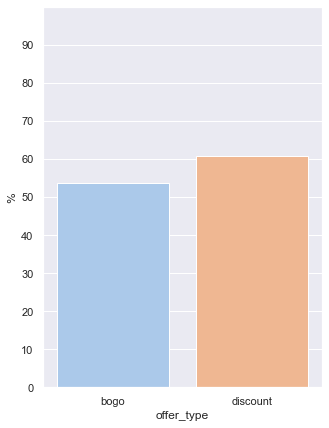

In [110]:
plt.figure(figsize=(5, 7))
sns.barplot(x='offer_type', y='%', data=comparison, palette='pastel')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.yticks(np.arange(0, 100, step=10))
plt.show()

На диаграмме заметно различие между акциями типа "2 по цене 1" (bogo) и скидочного типа (discount). Скидки находят больший отклик у клиентов - 60.9% конверсии против 53.7%.
Убедимся в статистической значимости полученного результата, используя критерий Хи-квадрат.

Создадим перекрестную таблицу с мильтииндексами для дальнейшего использования при расчете интересующей нас статистики

In [111]:
data_crosstab = pd.crosstab(offer_events_full['offer_type'],
                            offer_events_full['offer completed at list once'],
                           margins=True, margins_name="Total")
data_crosstab

offer completed at list once,0,1,Total
offer_type,,,
bogo,11734,13587,25321
discount,9907,15409,25316
Total,21641,28996,50637


In [112]:
alpha = 0.05

In [113]:
chi_square = 0
rows = offer_events_full['offer_type'].unique()
columns = offer_events_full['offer completed at list once'].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E
        
p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = 'Гипотеза о равенстве не может быть отклонена.'
if p_value <= alpha:
    conclusion = 'Гипотеза о равенстве может быть отклонена.'
print('Хи-квадрат статистика: {}'.format(chi_square),
      'p-value: {}'.format(p_value),
      conclusion, sep='\n')

Хи-квадрат статистика: 268.72814015307733
p-value: 0.0
Гипотеза о равенстве может быть отклонена.


Различия действительно есть. Это неудивительно, так как скидки являются наиболее гибким и привычным для клиентов стимулом.

In [114]:
offer_events_full.duration.value_counts()

7     25339
10    12706
5     12592
Name: duration, dtype: int64

In [115]:
comparison = offer_events_full.groupby('duration', as_index = False)\
                              .agg({'person':'count','offer completed at list once':'sum'})
comparison = comparison.rename(columns={'person':'total', 'offer completed at list once':'completed'})
comparison['%'] = round(comparison['completed'] * 100 / comparison['total'], 1)
comparison

,duration,total,completed,%
0,5,12592,6626,52.6
1,7,25339,14862,58.7
2,10,12706,7508,59.1


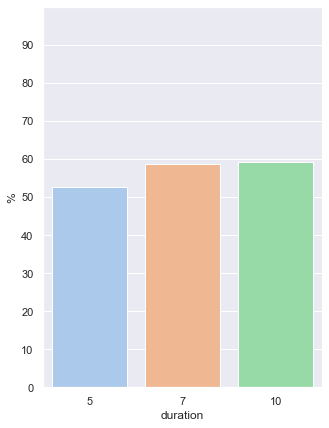

In [116]:
plt.figure(figsize=(5, 7))
sns.barplot(x='duration', y='%', data=comparison, palette='pastel')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.yticks(np.arange(0, 100, step=10))
plt.show()

На диаграмме видно различие между акциями длительностью 5 дней и акциями длительностью 7 или 10 дней, что вполне логично: чем дольше длится акция, тем больше клиентов хотя бы раз согласятся на участие в ней (52,6% конверсии против 58,7% и 59,1%, соответственно). Однако, различие между 7- и 10-дневными акциями не столь существенны.
Убедимся в статистической значимости полученного результата, используя критерий Хи-квадрат.

Для дальнейшего расчета Хи-квадрат статистики и p-value создадим функцию chisquare:

In [117]:
def chisquare(a, b, alpha):
    data_crosstab = pd.crosstab(a,b,margins=True,margins_name='Total')
    chi_square = 0
    rows = a.unique()
    columns = b.unique()
    for i in columns:
        for j in rows:
            O = data_crosstab[i][j]
            E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
            chi_square += (O-E)**2/E
            
    p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
    conclusion = "Гипотеза о равенстве не может быть отклонена."
    if p_value <= alpha:
        conclusion = "Гипотеза о равенстве может быть отклонена."
    return print("Хи-квадрат статистика: {}".format(chi_square),
                 "p-value: {}".format(p_value),
                 conclusion, sep='\n')

Рассчитаем соответствующую статистику по 5- и 7-дневным акциям:

In [118]:
chisquare(offer_events_full[offer_events_full.duration != 10].duration,
          offer_events_full[offer_events_full.duration != 10]['offer completed at list once'],
          0.05)

Хи-квадрат статистика: 124.62870389071172
p-value: 0.0
Гипотеза о равенстве может быть отклонена.


Различия в конверсии между акциями длительностью 5 и 7 дней статистически значимы.

Рассчитаем соответствующую статистику по 7- и 10-дневным акциям:

In [119]:
chisquare(offer_events_full[offer_events_full.duration != 5].duration,
          offer_events_full[offer_events_full.duration != 5]['offer completed at list once'],
          0.05)

Хи-квадрат статистика: 0.6686914424896335
p-value: 0.6297942859864152
Гипотеза о равенстве не может быть отклонена.


Различия между 7- и 10-дневными акциями не значимы, как и ожидалось. Скорее всего, это связано с периодичностью посещения клиентами кафе. Предложения по всем акциям отправлялись клиентам в одинаковое время. Соответственно, если клиент не использовал акционное предложение в течение первой недели, то вероятность его использования в первые три дня следующей недели невысока, так как в кофейни люди ходят обычно с периодичностью 1-2 дня, и в течение 7 дней их отношение к той или иной акции уже сформмировано.

Теперь обратим внимание на показатели акций типа дисконт:

In [120]:
offers_report[offers_report.offer_type == 'discount']

,id,offer_type,duration,reward,difficulty,channels,offer received,offer completed,%
0,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']",7597.0,5265.0,69.3
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']",7646.0,5112.0,66.9
4,2906b810c7d4411798c6938adc9daaa5,discount,7,2,10,"['web', 'email', 'mobile']",7632.0,3964.0,51.9
6,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,5,20,"['web', 'email']",7668.0,3340.0,43.6


Заметим, что несмотря на статистически подтвержденное превышение показателя конверсии по акциям типа дисконт над акциями типа bogo, не все акции типа дисконт "обогнали" акции типа bogo. Обратим внимание на параметры этих акций, различные с лидерами.
Акции типа дисконт с минимальными показателями вовлеченности имеют одно заметное различие по сравнению с лидирующими акциями указанного типа - это отсутсвие канала social.

In [121]:
offers_report[offers_report.offer_type == 'bogo']

,id,offer_type,duration,reward,difficulty,channels,offer received,offer completed,%
2,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",7571.0,4262.0,56.3
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"['web', 'email', 'mobile']",7677.0,4303.0,56.1
5,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,"['email', 'mobile', 'social']",7658.0,3635.0,47.5
7,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,"['web', 'email', 'mobile', 'social']",7593.0,3301.0,43.5


При этом по акциям вида bogo имеем несколько иную картину - по вовлеченности лидируют акции как без канала social, так и с ним, при этом в остальных акциях указанный канал присутствует.

Чтобы сделать однозначный вывод о влиянии наличия канала social на успешность вовлечения клиентов, проведем статистический анализ по типам акций отдельно и общий анализ.

In [122]:
comparison21 = offer_events_full[offer_events_full.offer_type == 'bogo'].groupby('social', as_index = False)\
                              .agg({'person':'count','offer completed at list once':'sum'})
comparison21 = comparison21.rename(columns={'person':'total', 'offer completed at list once':'completed'})
comparison21['%'] = round(comparison21['completed'] * 100 / comparison21['total'], 1)
comparison21

,social,total,completed,%
0,0,6355,3784,59.5
1,1,18966,9803,51.7


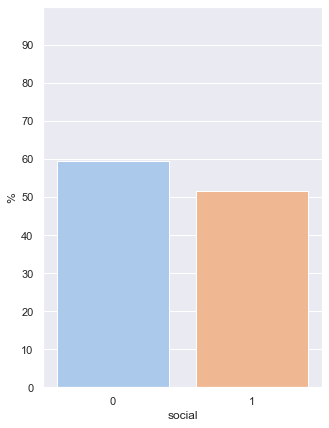

In [123]:
plt.figure(figsize=(5, 7))
sns.barplot(x='social', y='%', data=comparison21, palette='pastel')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.yticks(np.arange(0, 100, step=10))
plt.show()

Для акций типа bogo наличие канала social не является фактором успеха. Проверим данное утверждение статистически. 

In [124]:
chisquare(offer_events_full[offer_events_full.offer_type == 'bogo'].social,
         offer_events_full[offer_events_full.offer_type == 'bogo']['offer completed at list once'],
         0.05)

Хи-квадрат статистика: 118.15543901145585
p-value: 0.0
Гипотеза о равенстве может быть отклонена.


Статистически достоверно наличие канала social не коррелирует с успехом по показателю вовлеченности для акций типа bogo.

Посмотрим, как обстоят дела с акцями типа дисконт

In [125]:
comparison = offer_events_full[offer_events_full.offer_type == 'discount'].groupby('social', as_index = False)\
                              .agg({'person':'count','offer completed at list once':'sum'})
comparison = comparison.rename(columns={'person':'total', 'offer completed at list once':'completed'})
comparison['%'] = round(comparison['completed'] * 100 / comparison['total'], 1)
comparison

,social,total,completed,%
0,0,12659,6458,51.0
1,1,12657,8951,70.7


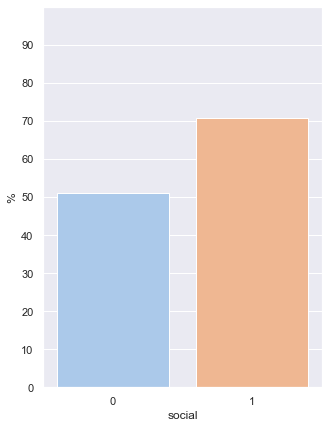

In [126]:
plt.figure(figsize=(5, 7))
sns.barplot(x='social', y='%', data=comparison, palette='pastel')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.yticks(np.arange(0, 100, step=10))
plt.show()

Для акций типа дисконт наличие канала social, возможно, является фактором успеха, так как на лицо более высокое значение показателя конверсии предложений с наличием указанного канала. Проверим данное утверждение статистически. 

In [127]:
chisquare(offer_events_full[offer_events_full.offer_type == 'discount'].social,
         offer_events_full[offer_events_full.offer_type == 'discount']['offer completed at list once'],
         0.05)

Хи-квадрат статистика: 1031.6848601967822
p-value: 0.0
Гипотеза о равенстве может быть отклонена.


Ожидаемо, различие подтверждено статистически.

Таким образом, выявлено, что акции типа дисконт в среднем более успешны, чем акции типа bogo. При этом для акций типа дисконт важным каналом коммуникации является канал social.

Рассмотрим показатель просматриваемости акций информационного типа.

In [128]:
offers_report_inf = offers.merge(offer_events_piv, how='left', left_on='id', right_on='offer_id')\
.drop(columns=['offer completed', 'offer_id'])
offers_report_inf['%'] = round(offers_report_inf['offer viewed'] * 100 / offers_report_inf['offer received'], 1)
offers_report_inf = offers_report_inf[offers_report_inf.offer_type == 'informational']\
.sort_values('%', ascending = False).reset_index(drop=True)
offers_report_inf

,id,offer_type,duration,reward,difficulty,channels,email,web,mobile,social,offer received,offer viewed,%
0,5a8bc65990b245e5a138643cd4eb9837,informational,3,0,0,"['email', 'mobile', 'social']",1,0,1,1,7618.0,6687.0,87.8
1,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"['web', 'email', 'mobile']",1,1,1,0,7617.0,4144.0,54.4


Главным отличием акции информационного типа с высоким показателем просматриваемости является наличие канала social. Несмотря на меньшую длительность (duration) данная акция заметно выигрывает. В отсутствие дополнительных характеристик данных акций можно сделать вывод о том, что для акций информационного типа наиболее эффективным каналом коммуникации является канал social.

Далее проведем сегментацию клиентов для того, чтобы в дальнейшем определить, на какие группы клиентов какие акции действуют эффективнее.

Рассмотрим график распределения клиентов по возрастам подробно

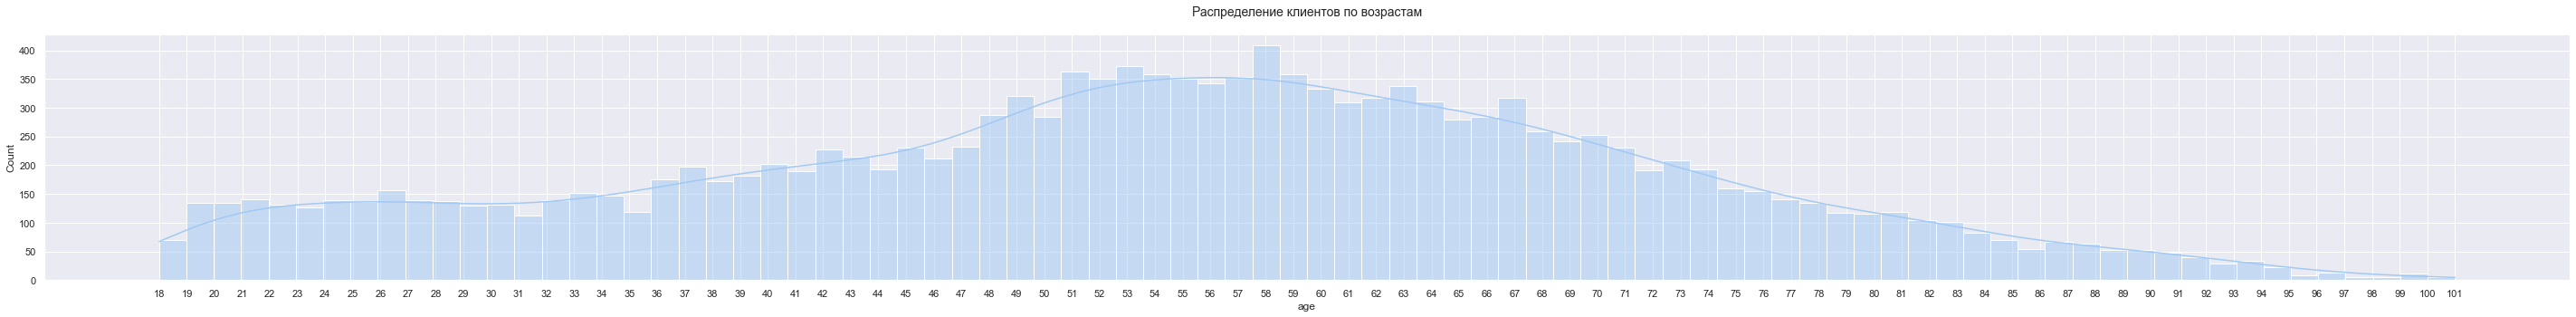

In [129]:
plt.figure(figsize = (50, 5))
ax = sns.histplot(x = customers.age, bins = customers.age.nunique(), kde=True)
ax.set_title('Распределение клиентов по возрастам', fontsize = 14, pad = 20)
plt.xticks(customers.age.unique())
plt.show()

In [130]:
customers.age.apply(['mean', 'median'])

mean      54.393524
median    55.000000
Name: age, dtype: float64

In [131]:
customers.age.mode()

0    58
dtype: int64

In [132]:
customers.age.quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

0.0     18.0
0.2     39.0
0.4     51.0
0.6     59.0
0.8     69.0
1.0    101.0
Name: age, dtype: float64

Мы видим, что клиенты распределены по возрасту неравномерно. Минимальный возраст составлят 18 лет, максимальный - 101 год. При этом 40% клиентов обладают возрастом от 51 до 69 лет. Таким образом, основную часть составляют клиенты в зрелом возрасте. На графике это также заметно - рост частот встречаемости возраста начинается примерно с 48 затем достигает пика в 58, далее плавно опускается.

Линия kde имеет слабо выраженный локальный минимум в точке 30 и перегиб в точке 45, на остальной части графика сколько-нибудь выраженные точки изменения угла изгиба отсутствуют.

С учетом вышеизложенного для сбалансированности сегментов и удобства восприятия разделим клиентов по возрастным группам с границами, примерно совпадающим с границами квантилей, с учетом общих представлений о возрастных группах:

1) 18-35

2) 36-50

3) 50-65

4) 65-75

5) 71-101

In [133]:
def age_define(x):
    if x <= 35:
        return '18-35'
    if 35 < x <= 50:
        return '36-50'
    if 50 < x <= 60:
        return '50-60'
    if 60 < x <= 70:
        return '61-70'
    else:
        return '>70'

In [134]:
customers['age_group'] = customers.age.apply(age_define)

In [135]:
customers.head()

,gender,age,id,became_member_on,income,bmo_weekday,age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,Saturday,50-60
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,Tuesday,>70
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,Thursday,61-70
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,Friday,61-70
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,Saturday,50-60


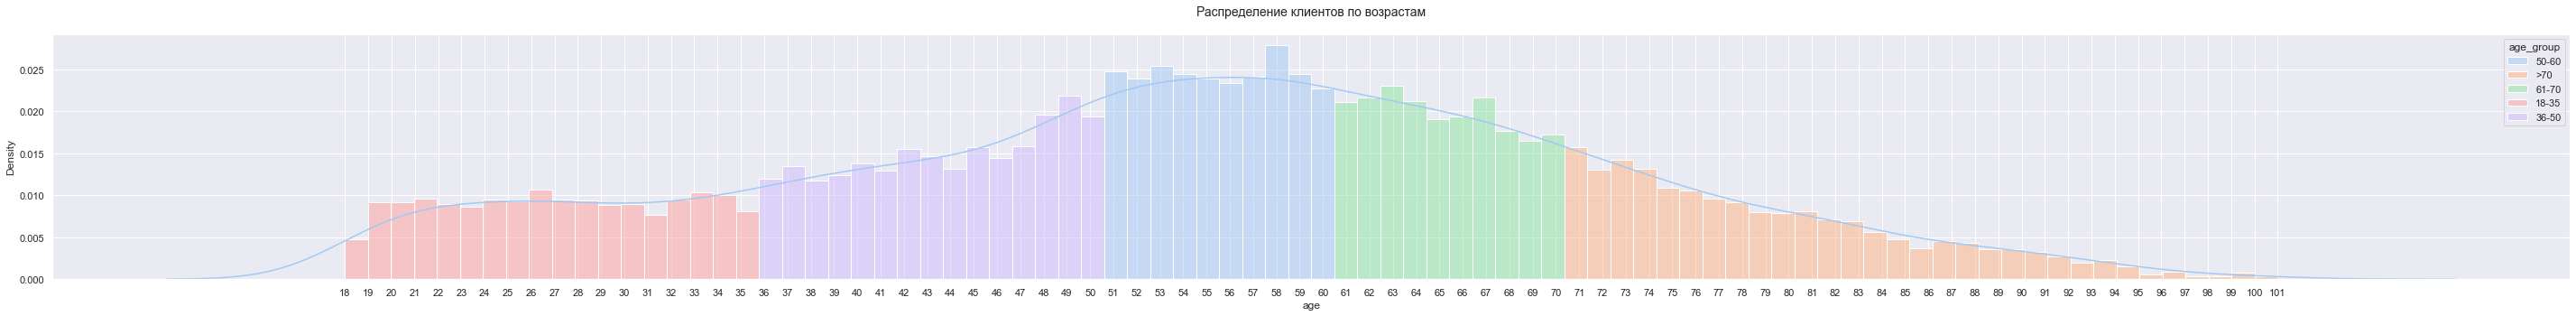

In [136]:
plt.figure(figsize = (50, 5))
ax = sns.histplot(data = customers, x = 'age', bins = customers.age.nunique(), kde=False, stat='density',
                  hue='age_group')
sns.kdeplot(data = customers, x = 'age', ax=ax)
plt.xticks(customers.age.unique())
ax.set_title('Распределение клиентов по возрастам', fontsize = 14, pad = 20)
plt.show()

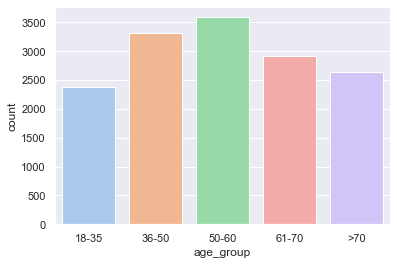

In [137]:
age_percentage = customers.groupby('age_group', as_index=False).agg({'id':'count', 'age':'mean'})\
.sort_values('age', ignore_index=True).rename(columns={'id':'count'})
age_percentage['%'] = round(age_percentage['count'] * 100 / age_percentage['count'].sum(), 1)
ax = sns.barplot(x = age_percentage.age_group, y = age_percentage['count'], palette = 'pastel')
plt.show()

In [138]:
age_percentage[['count', '%']].apply(['min', 'max'])

,count,%
min,2374,16.0
max,3590,24.2


Сегменты получились сбалансированными, сходными с формой распределения по возрастам.

Теперь проведем сегментацию по уровню дохода.

Еще раз посмотрим на параметры распределения:

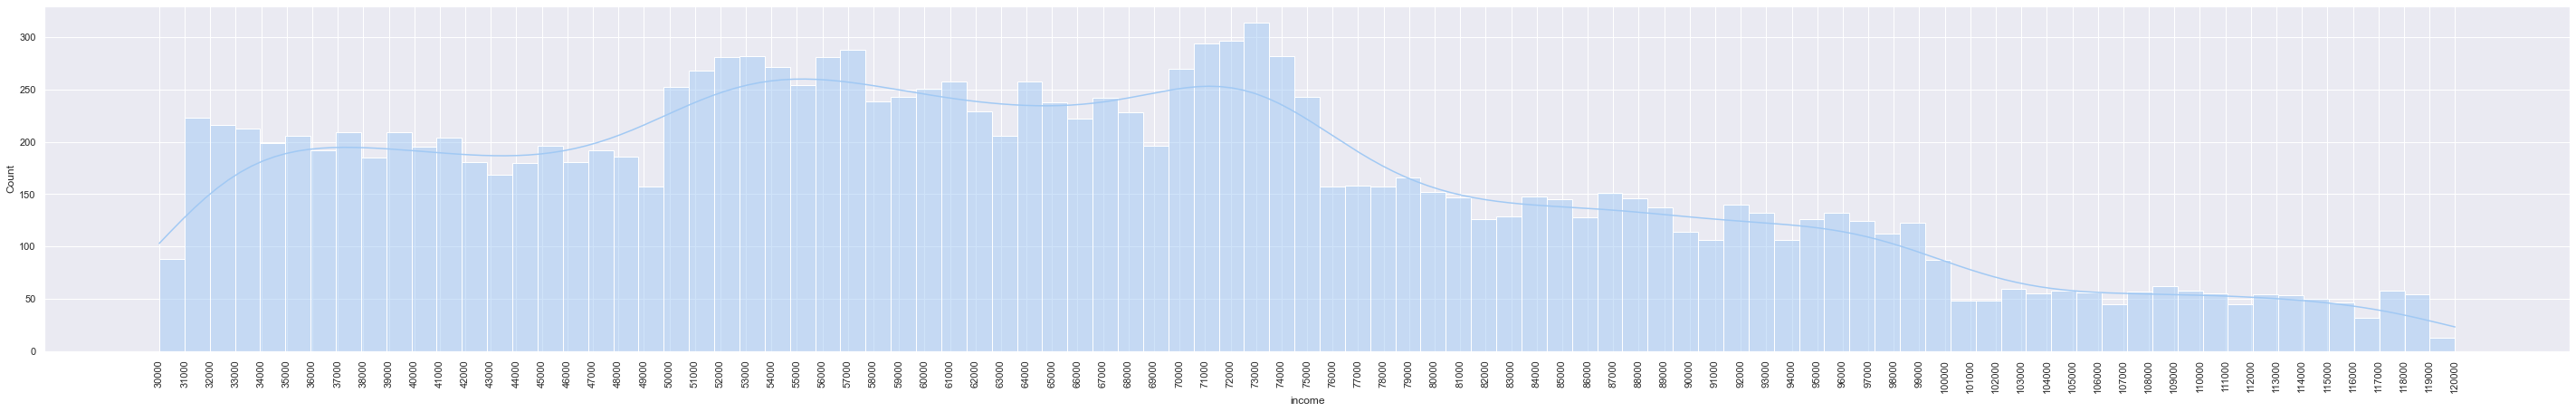

In [139]:
plt.figure(figsize = (50, 7))
sns.histplot(customers.income, bins = customers.income.nunique(), palette = 'pastel', kde=True)
plt.xticks(customers.income.unique(), rotation = 90)
plt.show()

In [140]:
customers.income.apply(['mean', 'median']).apply(round)

mean      65405
median    64000
Name: income, dtype: int64

In [141]:
customers.income.mode()

0    73000.0
dtype: float64

In [142]:
customers.income.quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

0.0     30000.0
0.2     45000.0
0.4     57000.0
0.6     70000.0
0.8     85000.0
1.0    120000.0
Name: income, dtype: float64

На гистограмме линия kde имеет выраженные локальные минимумы в точках 43 и 65, а также перегибы в точках 80 и 105.

С учетом вышеизложеного, а также данных о квантилях, разделим данные на 5 сегментов, по следующим границам:

1) 30-43 тыс. - bottom

2) 43-55 тыс. - poor

3) 56-65 тыс. - middle class

4) 66-80 тыс. - wealthy

5) 81-120 тыс. - oligarch

In [143]:
def income_define(x):
    if x <= 43000:
        return 'bottom'
    if 43000 < x <= 55000:
        return 'poor'
    if 55000 < x <= 65000:
        return 'middle class'
    if 65000 < x <= 80000:
        return 'wealthy'
    else:
        return 'oligarch'

In [144]:
customers['income_group'] = customers.income.apply(income_define)

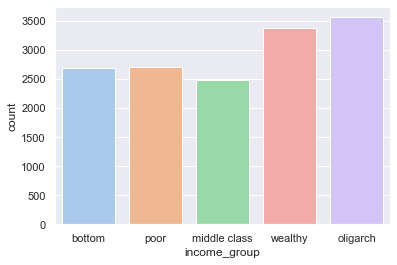

In [145]:
income_percentincome = customers.groupby('income_group', as_index=False).agg({'id':'count', 'income':'mean'})\
.sort_values('income', ignore_index=True).rename(columns={'id':'count'})
income_percentincome['%'] = round(income_percentincome['count'] * 100 / income_percentincome['count'].sum(), 1)
ax = sns.barplot(x = income_percentincome.income_group, y = income_percentincome['count'], palette = 'pastel')
plt.show()

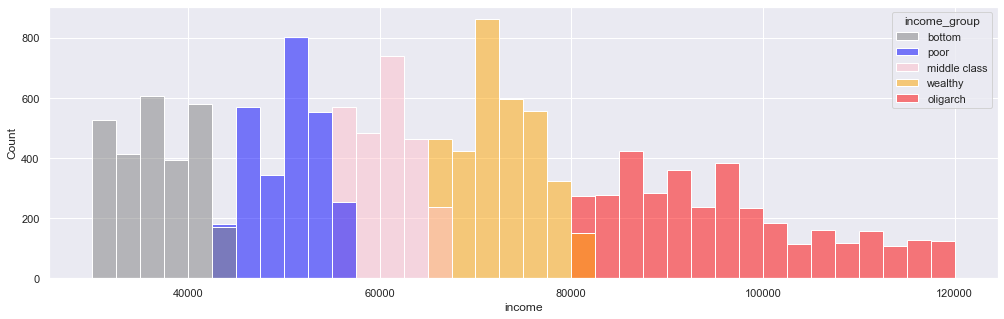

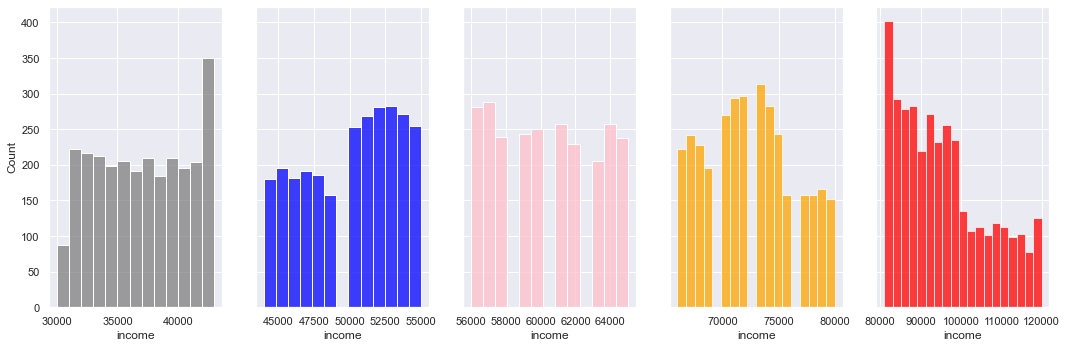

In [146]:
plt.figure(figsize = (17, 5))
sns.histplot(data = customers.sort_values('income'), x = 'income', hue = 'income_group', 
             palette = ['grey', 'blue', 'pink', 'orange', 'red'])

fig, ax = plt.subplots(1, 5, figsize = (15, 5), sharey = True)
sns.histplot(customers[customers.income_group == 'bottom'].income, ax = ax[0], color = 'grey')
sns.histplot(customers[customers.income_group == 'poor'].income, ax = ax[1], color = 'blue')
sns.histplot(customers[customers.income_group == 'middle class'].income, ax = ax[2], color = 'pink')
sns.histplot(customers[customers.income_group == 'wealthy'].income, ax = ax[3], color = 'orange')
sns.histplot(customers[customers.income_group == 'oligarch'].income, ax = ax[4], color = 'red')
plt.tight_layout()

Группы получились в целом сбалансированными, с перевесом в сторону хорошо обеспеченных клиентов. Это вам не cofix! ;)

Теперь подтянем данные о клиентах к данным о событиях и выявим, какие виды акций больше откликались у определенных сегментов.

In [147]:
customers

,gender,age,id,became_member_on,income,bmo_weekday,age_group,income_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,Saturday,50-60,oligarch
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,Tuesday,>70,oligarch
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,Thursday,61-70,wealthy
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,Friday,61-70,poor
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,Saturday,50-60,poor
...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,Monday,36-50,poor
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,Friday,61-70,wealthy
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,Thursday,36-50,wealthy
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,Monday,>70,poor


In [148]:
offer_events_full_cust = offer_events_full.merge(customers, how='left', left_on = 'person', right_on = 'id')\
.drop(columns=['id', 'became_member_on', 'bmo_weekday', 'email', 'offer received', 'offer viewed'])
offer_events_full_cust.head()

,person,offer_id,offer completed at list once,offer_type,duration,reward,difficulty,channels,web,mobile,social,offer completed,gender,age,income,age_group,income_group
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,discount,7,2,10,"['web', 'email', 'mobile']",1,1,0,1,M,33.0,72000.0,18-35,wealthy
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",1,1,1,1,M,33.0,72000.0,18-35,wealthy
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,discount,10,2,10,"['web', 'email', 'mobile', 'social']",1,1,1,1,M,33.0,72000.0,18-35,wealthy
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",1,1,1,0,NaN,NaN,NaN,NaN,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,discount,10,5,20,"['web', 'email']",1,0,0,1,O,40.0,57000.0,36-50,middle class


In [149]:
offer_events_full_cust.isna().sum()

person                             0
offer_id                           0
offer completed at list once       0
offer_type                         0
duration                           0
reward                             0
difficulty                         0
channels                           0
web                                0
mobile                             0
social                             0
offer completed                    0
gender                          6456
age                             6456
income                          6456
age_group                       6456
income_group                    6456
dtype: int64

Исключим из анализа клиентов, данных о которых нет в нашей базе 

In [150]:
offer_events_full_cust = offer_events_full_cust.dropna()

In [151]:
offer_events_full_cust.head()

,person,offer_id,offer completed at list once,offer_type,duration,reward,difficulty,channels,web,mobile,social,offer completed,gender,age,income,age_group,income_group
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,discount,7,2,10,"['web', 'email', 'mobile']",1,1,0,1,M,33.0,72000.0,18-35,wealthy
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",1,1,1,1,M,33.0,72000.0,18-35,wealthy
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,discount,10,2,10,"['web', 'email', 'mobile', 'social']",1,1,1,1,M,33.0,72000.0,18-35,wealthy
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,discount,10,5,20,"['web', 'email']",1,0,0,1,O,40.0,57000.0,36-50,middle class
5,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,discount,7,3,7,"['web', 'email', 'mobile', 'social']",1,1,1,1,O,40.0,57000.0,36-50,middle class


Для начала оценим общую реакцию клиентов на рекламые предложения в зависимости от их пола, возраста и уровня дохода

In [152]:
com_gender = offer_events_full_cust.groupby('gender', as_index = False)\
                              .agg({'person':'count','offer completed at list once':'sum'})
com_gender = com_gender.rename(columns={'person':'total', 'offer completed at list once':'completed'})
com_gender['%'] = round(com_gender['completed'] * 100 / com_gender['total'], 1)
com_gender

,gender,total,completed,%
0,F,18207,13259,72.8
1,M,25368,14254,56.2
2,O,606,429,70.8


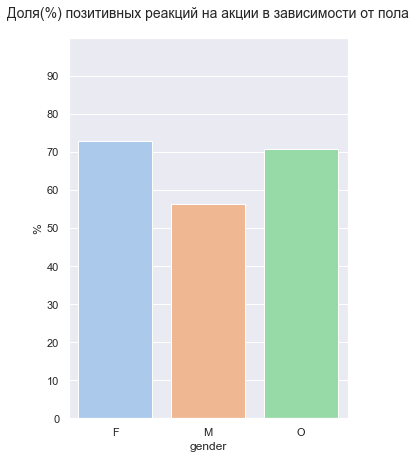

In [153]:
plt.figure(figsize=(5, 7))
sns.barplot(x='gender', y='%', data=com_gender, palette='pastel')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.yticks(np.arange(0, 100, step=10))
ax.set_title('Доля(%) позитивных реакций на акции в зависимости от пола', fontsize=14, pad=20)
plt.show()

Очевидно, женщины и небинарные личности реагируют на поступающие акционные предложения охотнее мужчин. 

In [154]:
com_age = offer_events_full_cust.groupby('age_group', as_index = False)\
                              .agg({'person':'count','offer completed at list once':'sum'})
com_age = com_age.rename(columns={'person':'total', 'offer completed at list once':'completed'})
com_age['%'] = round(com_age['completed'] * 100 / com_age['total'], 1)
com_age

,age_group,total,completed,%
0,18-35,7176,3639,50.7
1,36-50,9828,6069,61.8
2,50-60,10760,7210,67.0
3,61-70,8666,5740,66.2
4,>70,7751,5284,68.2


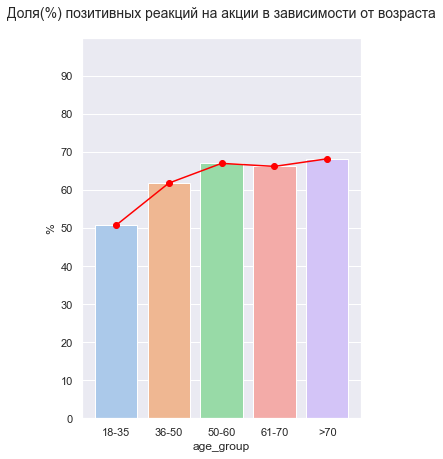

In [155]:
plt.figure(figsize=(5, 7))
sns.barplot(x='age_group', y='%', data=com_age, palette='pastel')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.yticks(np.arange(0, 100, step=10))
ax.set_title('Доля(%) позитивных реакций на акции в зависимости от возраста', fontsize=14, pad=20)
plt.plot(com_age.age_group, com_age['%'], '-o', color='red')
plt.show()

Прослеживается тренд на увеличение позитивных реакций на акции с возрастом

In [156]:
com_income = offer_events_full_cust.groupby('income_group', as_index = False)\
                              .agg({'income':'mean', 'person':'count','offer completed at list once':'sum'})\
.sort_values('income')
com_income = com_income.rename(columns={'income':'income_mean', 'person':'total', 'offer completed at list once':'completed'})
com_income.income_mean = round(com_income.income_mean, 1)
com_income['%'] = round(com_income['completed'] * 100 / com_income['total'], 1)
com_income

,income_group,income_mean,total,completed,%
0,bottom,36509.8,8045,3629,45.1
3,poor,50061.2,8058,4480,55.6
1,middle class,60307.1,7404,4569,61.7
4,wealthy,72417.5,10031,6869,68.5
2,oligarch,95697.6,10643,8395,78.9


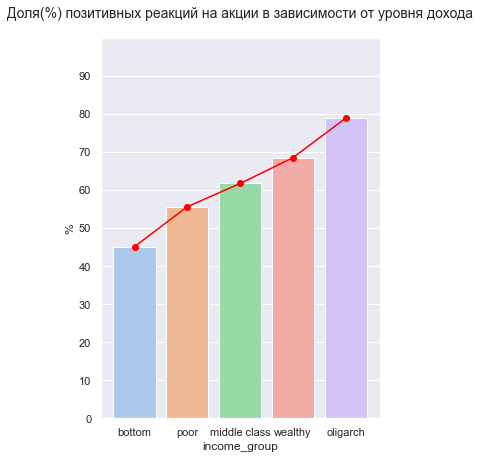

In [157]:
plt.figure(figsize=(5, 7))
sns.barplot(x='income_group', y='%', data=com_income, palette='pastel')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.yticks(np.arange(0, 100, step=10))
ax.set_title('Доля(%) позитивных реакций на акции в зависимости от уровня дохода', fontsize=14, pad=20)
plt.plot(com_income.income_group, com_income['%'], '-o', color='red')
plt.show()

Прослеживается тренд на увеличение позитивных реакций на акции с ростом уровня дохода ;)) Единственное предположение - постоянными клиентами Старбакса являются обеспеченные люди, а у постояных клиентов лояльность выше. 

Только не говорите, что датасет сгенерирован слегка примитивно, это не так!

## Выводы по проведенному анализу эффективности рекламных предложений

Выводы:
1) Акции типа дисконт в среднем более успешны, чем акции типа bogo. При этом для акций типа дисконт важным каналом коммуникации является канал social.

2) Чем дольше длительность акции, тем больше по ней отклик клиентов (52,6% конверсии по акциям длительностью 5 дней против 58,7% и 59,1% по акциям длительностью 7 и 10 дней, соответственно).

3) Для акций информационного типа наиболее эффективным каналом коммуникации является канал social (показатель просматриваемости 87.8 % при наличии канала social против 54.4 % при его отсутствии).

4) Женщины и небинарные личности реагируют на поступающие акционные предложения охотнее мужчин (72.8% и 70.8% против 56.2% конверсии, соответственно).

5) Прослеживается тренд на увеличение позитивных реакций на акции с возрастом, а также с ростом уровня дохода.
Для подтверждения статистической значимости полученных результатов использовался критерий Хи-квадрат.


## 3. Приложение. Кластерный анализ методом k-means

Проведем кластерный анализ клиентов по возрасту и уровню дохода.

In [158]:
customers.head()

,gender,age,id,became_member_on,income,bmo_weekday,age_group,income_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,Saturday,50-60,oligarch
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,Tuesday,>70,oligarch
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,Thursday,61-70,wealthy
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,Friday,61-70,poor
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,Saturday,50-60,poor


<AxesSubplot:xlabel='age', ylabel='income'>

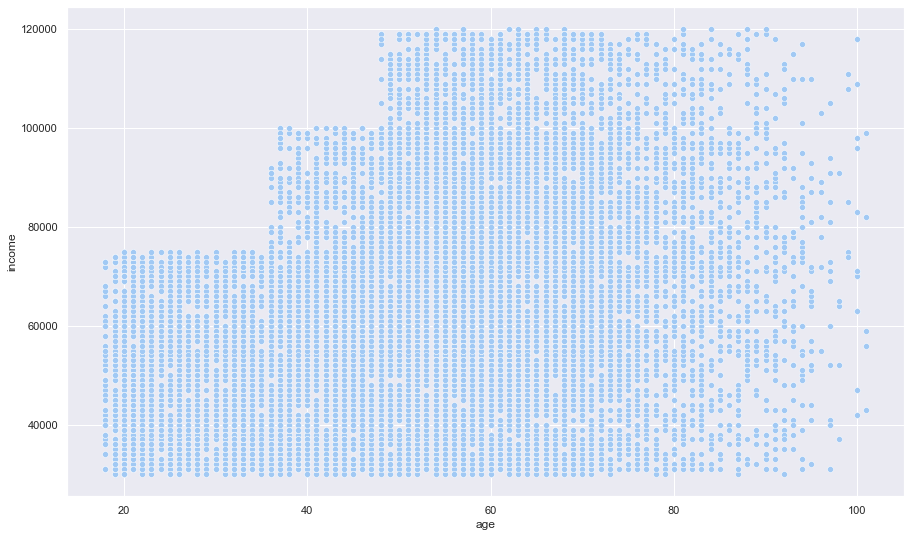

In [159]:
plt.figure(figsize = (15, 9))
sns.scatterplot(data = customers, x = 'age', y = 'income')

На графике различимы как минимум 3 группы точек, примем количество центроидов равным 3

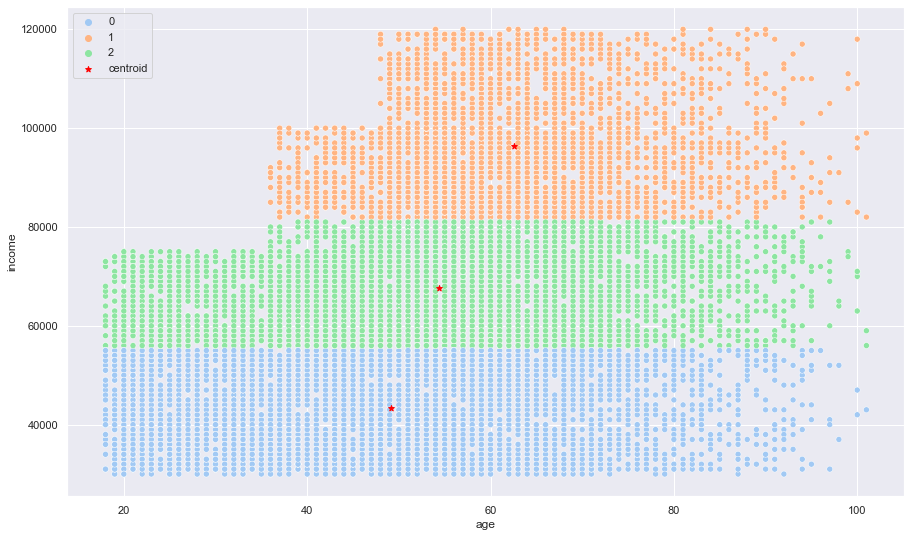

In [160]:
km3 = KMeans(n_clusters=3)
y_predicted3 = km3.fit_predict(customers[['age','income']])

customers_3cl = customers.copy()
customers_3cl['cluster'] = y_predicted3

plt.figure(figsize = (15, 9))
sns.scatterplot(data = customers_3cl, x = 'age', y = 'income', hue = 'cluster', palette = 'pastel')
plt.scatter(km3.cluster_centers_[:,0],km3.cluster_centers_[:,1],color='red',marker='*',label='centroid')
plt.legend()

Обе верхние "ступеньки" попали в один диапазон. Проэкспериментируем с увеличением k

In [161]:
customers.head(3)

,gender,age,id,became_member_on,income,bmo_weekday,age_group,income_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,Saturday,50-60,oligarch
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,Tuesday,>70,oligarch
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,Thursday,61-70,wealthy


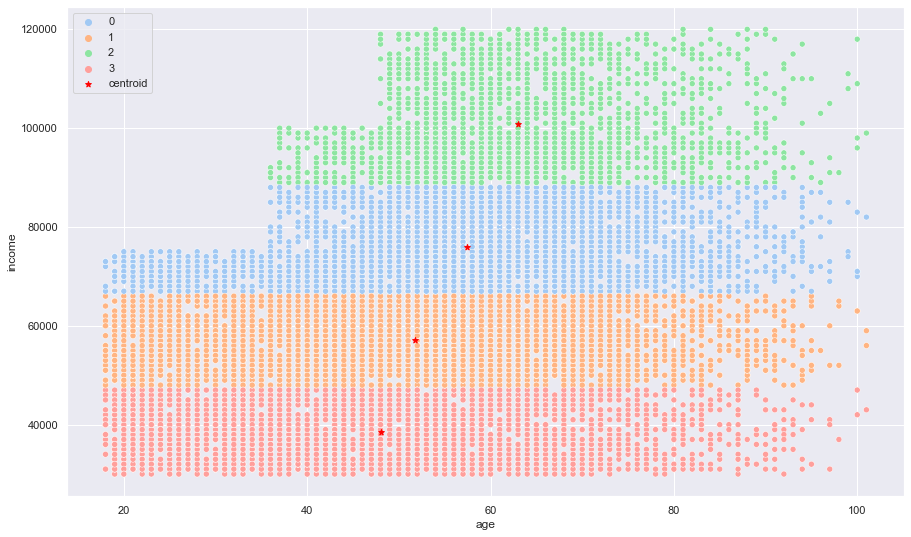

In [162]:
km4 = KMeans(n_clusters=4)
y_predicted4 = km4.fit_predict(customers[['age','income']])

customers_4cl = customers.copy()
customers_4cl['cluster'] = y_predicted4

plt.figure(figsize = (15, 9))
sns.scatterplot(data = customers_4cl, x = 'age', y = 'income', hue = 'cluster', palette = 'pastel')
plt.scatter(km4.cluster_centers_[:,0],km4.cluster_centers_[:,1],color='red',marker='*',label='centroid')
plt.legend()

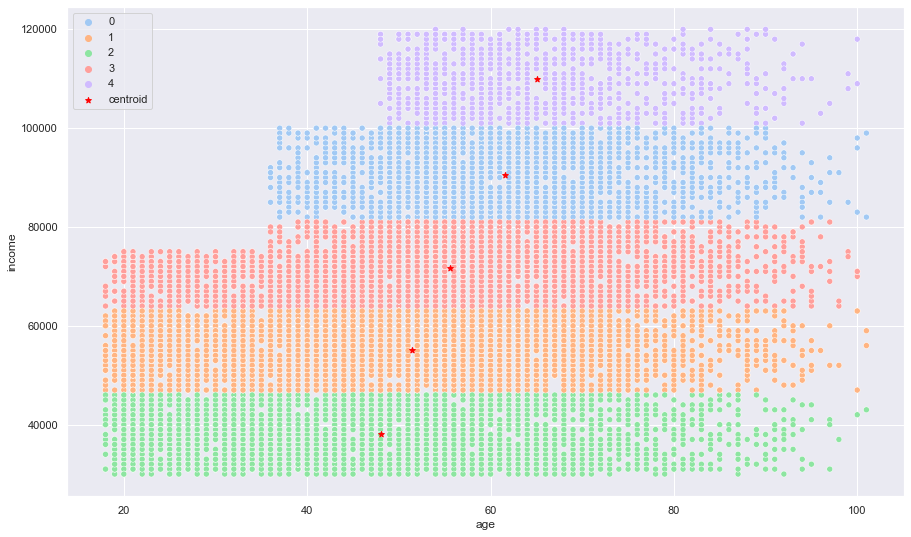

In [163]:
km5 = KMeans(n_clusters=5)
y_predicted5 = km5.fit_predict(customers[['age','income']])

customers_5cl = customers.copy()
customers_5cl['cluster'] = y_predicted5

plt.figure(figsize = (15, 9))
sns.scatterplot(data = customers_5cl, x = 'age', y = 'income', hue = 'cluster', palette = 'pastel')
plt.scatter(km5.cluster_centers_[:,0],km5.cluster_centers_[:,1],color='red',marker='*',label='centroid')
plt.legend()

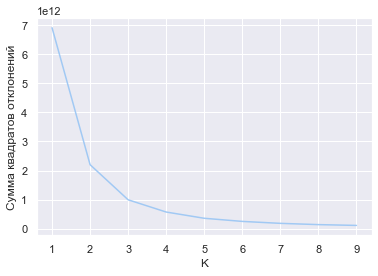

In [164]:
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(customers[['age','income']])
    sse.append(km.inertia_)
plt.xlabel('K')
plt.ylabel('Сумма квадратов отклонений')
plt.plot(k_rng,sse)

На графике видно, что дальнейшее увеличение значения k не дает значительного уменьшения суммы квадратов разностей

Визуально, наиболее близким к интуитивному является разделение на кластеры при k = 5. 
Рассмотрим распределения внутри получившихся групп при различных значениях k.

При количестве кластеров, равном 3, разделение по доходам будет выглядеть так:

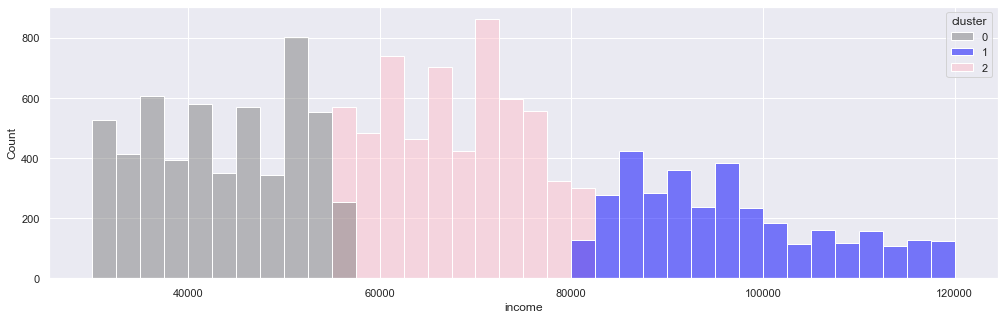

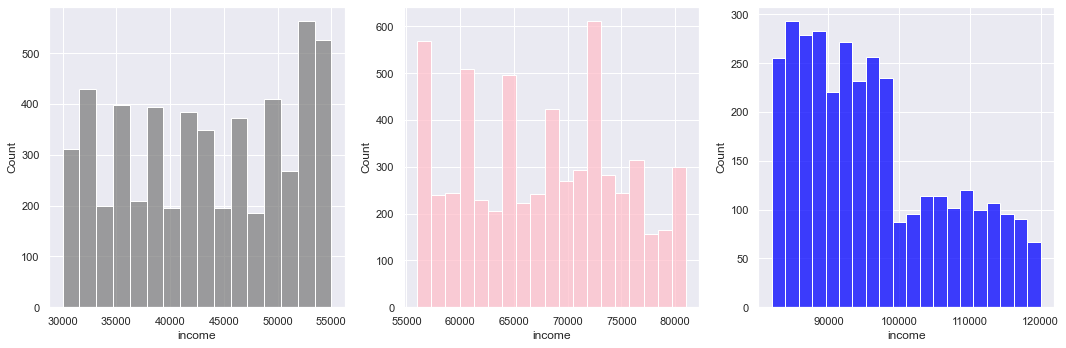

In [165]:
plt.figure(figsize = (17, 5))
sns.histplot(data = customers_3cl, x = 'income', hue = 'cluster', 
             palette = ['grey', 'blue', 'pink'])

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
sns.histplot(customers_3cl[customers_3cl.cluster == 0].income, ax = ax[0], color = 'grey')
sns.histplot(customers_3cl[customers_3cl.cluster == 1].income, ax = ax[2], color = 'blue')
sns.histplot(customers_3cl[customers_3cl.cluster == 2].income, ax = ax[1], color = 'pink')
plt.tight_layout()

Заметно явное смещение распределения влево на среднем графике (кластер "2") 

#### При количестве кластеров, равном 3, разделение по возрастам будет выглядеть так:

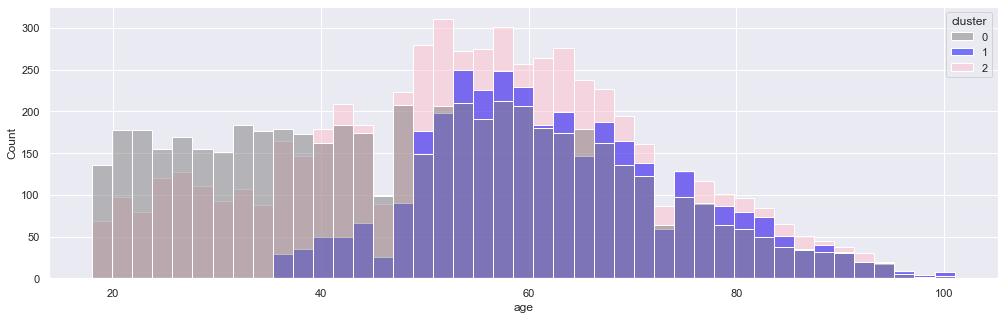

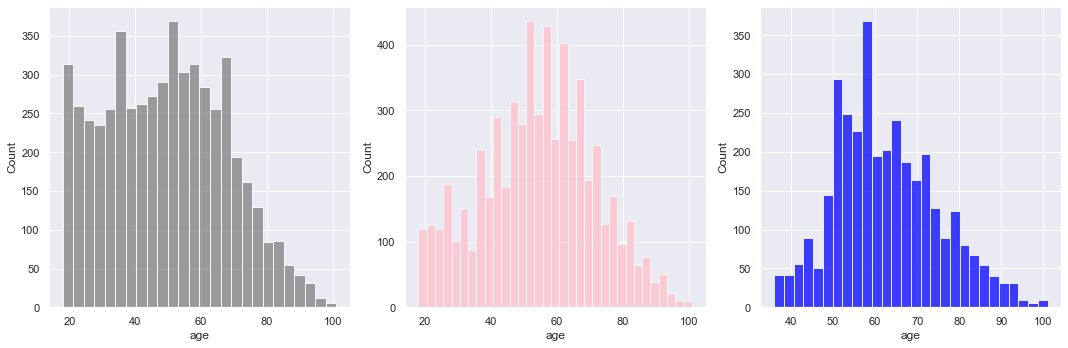

In [166]:
plt.figure(figsize = (17, 5))
sns.histplot(data = customers_3cl, x = 'age', hue = 'cluster', 
             palette = ['grey', 'blue', 'pink'])

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
sns.histplot(customers_3cl[customers_3cl.cluster == 0].age, ax = ax[0], color = 'grey')
sns.histplot(customers_3cl[customers_3cl.cluster == 1].age, ax = ax[2], color = 'blue')
sns.histplot(customers_3cl[customers_3cl.cluster == 2].age, ax = ax[1], color = 'pink')
plt.tight_layout()

На этом и последующих графиках распределения на группы методом k-means отсутствует четкое разделение по возрастным группам. При этом, внутри всех возрастных групп распределение близко к нормальному.

При количестве кластеров, равном 4, разделение по доходам будет выглядеть так:

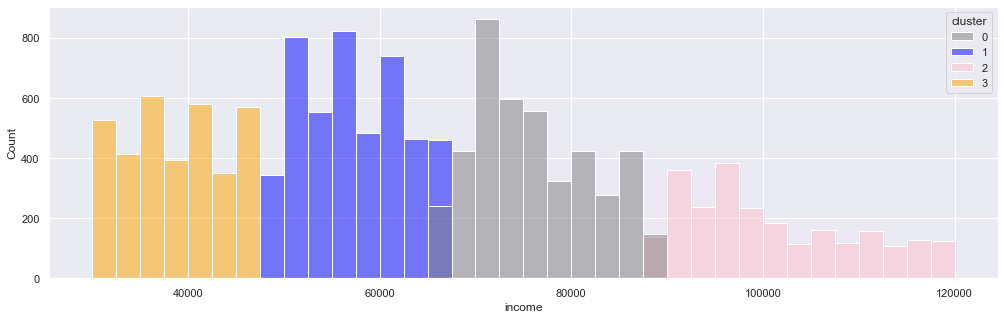

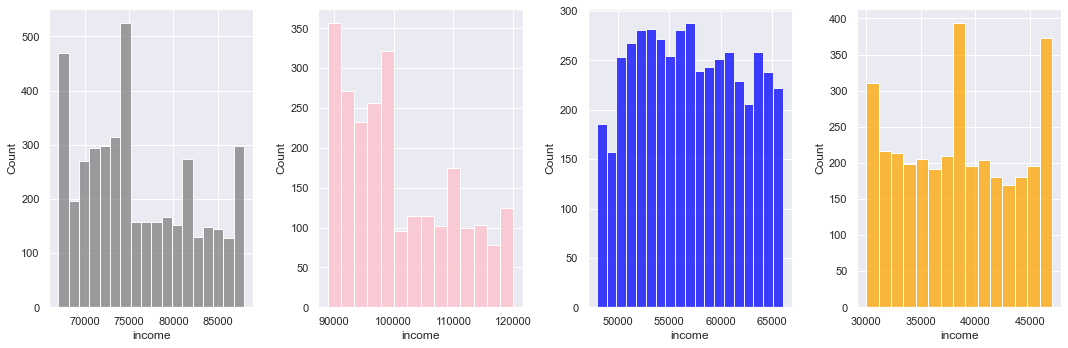

In [167]:
plt.figure(figsize = (17, 5))
sns.histplot(data = customers_4cl, x = 'income', hue = 'cluster', 
             palette = ['grey', 'blue', 'pink', 'orange'])

fig, ax = plt.subplots(1, 4, figsize = (15, 5))
sns.histplot(customers_4cl[customers_4cl.cluster == 0].income, ax = ax[0], color = 'grey')
sns.histplot(customers_4cl[customers_4cl.cluster == 1].income, ax = ax[2], color = 'blue')
sns.histplot(customers_4cl[customers_4cl.cluster == 2].income, ax = ax[1], color = 'pink')
sns.histplot(customers_4cl[customers_4cl.cluster == 3].income, ax = ax[3], color = 'orange')
plt.tight_layout()

Заметно явное смещение распределения влево на правом крайнем графике (кластер "2") 

При количестве кластеров, равном 4, разделение по возрастам будет выглядеть так:

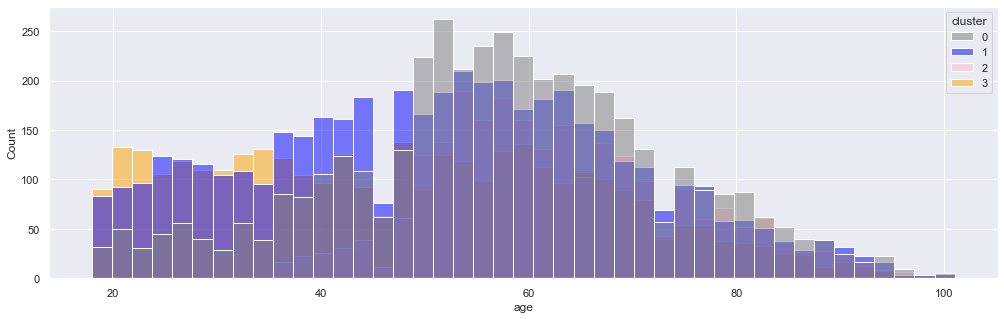

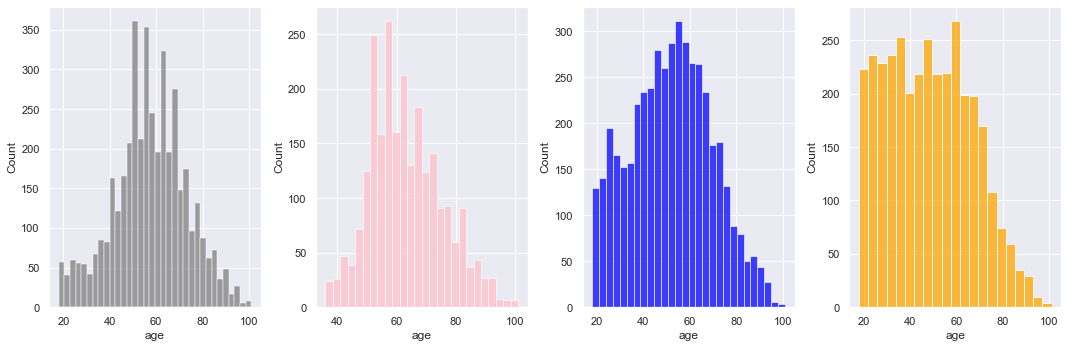

In [168]:
plt.figure(figsize = (17, 5))
sns.histplot(data = customers_4cl, x = 'age', hue = 'cluster', 
             palette = ['grey', 'blue', 'pink', 'orange'])

fig, ax = plt.subplots(1, 4, figsize = (15, 5))
sns.histplot(customers_4cl[customers_4cl.cluster == 0].age, ax = ax[0], color = 'grey')
sns.histplot(customers_4cl[customers_4cl.cluster == 1].age, ax = ax[2], color = 'blue')
sns.histplot(customers_4cl[customers_4cl.cluster == 2].age, ax = ax[1], color = 'pink')
sns.histplot(customers_4cl[customers_4cl.cluster == 3].age, ax = ax[3], color = 'orange')
plt.tight_layout()

При количестве кластеров, равном 5, разделение по доходам будет выглядеть так:

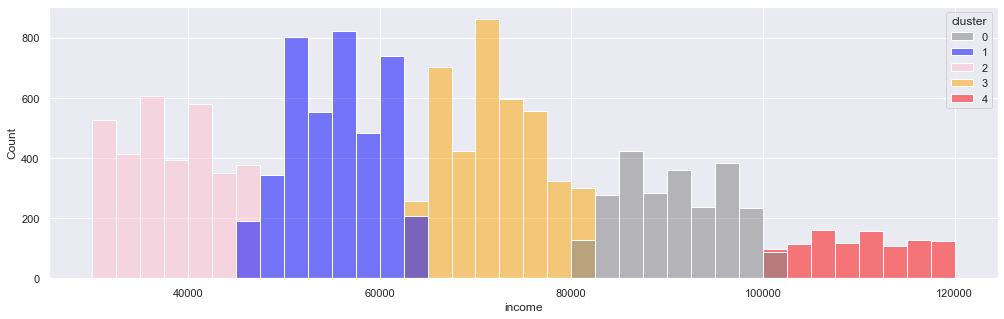

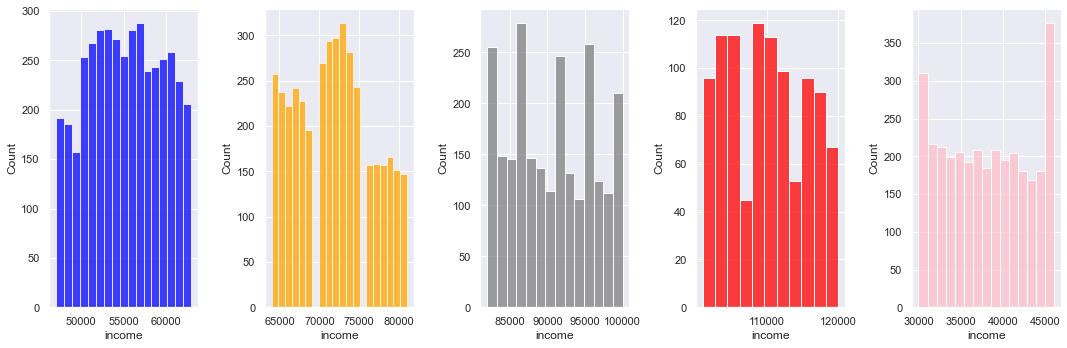

In [169]:
plt.figure(figsize = (17, 5))
sns.histplot(data = customers_5cl, x = 'income', hue = 'cluster', 
             palette = ['grey', 'blue', 'pink', 'orange', 'red'])

fig, ax = plt.subplots(1, 5, figsize = (15, 5))
sns.histplot(customers_5cl[customers_5cl.cluster == 0].income, ax = ax[2], color = 'grey')
sns.histplot(customers_5cl[customers_5cl.cluster == 1].income, ax = ax[0], color = 'blue')
sns.histplot(customers_5cl[customers_5cl.cluster == 2].income, ax = ax[4], color = 'pink')
sns.histplot(customers_5cl[customers_5cl.cluster == 3].income, ax = ax[1], color = 'orange')
sns.histplot(customers_5cl[customers_5cl.cluster == 4].income, ax = ax[3], color = 'red')
plt.tight_layout()

Разделение на кластеры по уровню дохода при k = 5 при точечной коррекции на границах наиболее оптимально, судя по форме распределений внутри групп

При количестве кластеров, равном 5, разделение по возрастам будет выглядеть так:

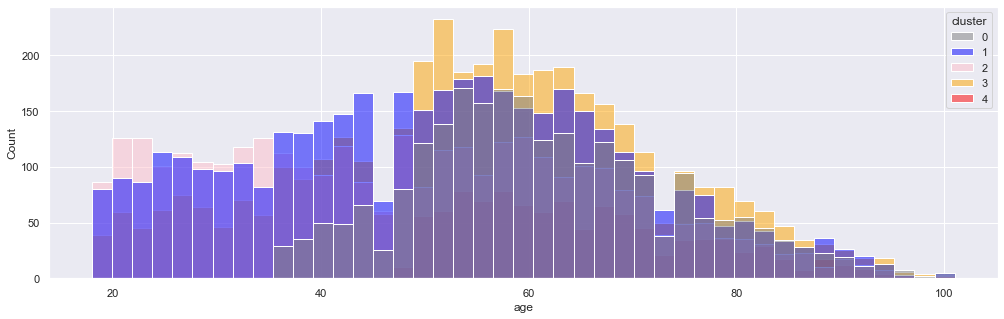

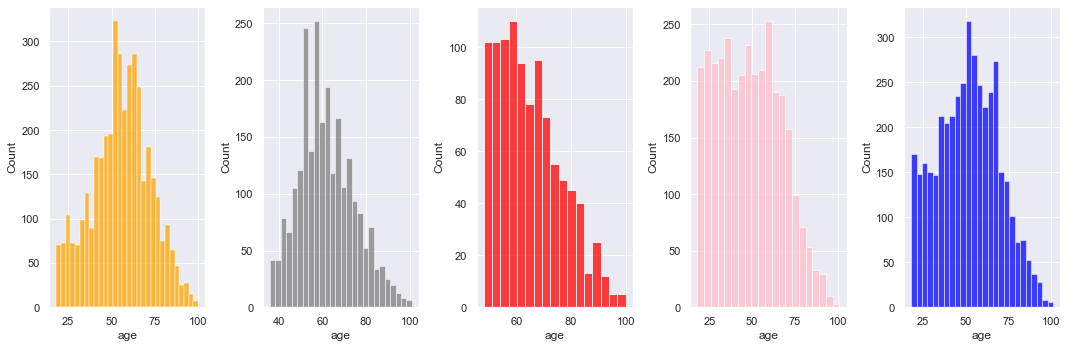

In [170]:
plt.figure(figsize = (17, 5))
sns.histplot(data = customers_5cl, x = 'age', hue = 'cluster', 
             palette = ['grey', 'blue', 'pink', 'orange', 'red'])

fig, ax = plt.subplots(1, 5, figsize = (15, 5))
sns.histplot(customers_5cl[customers_5cl.cluster == 0].age, ax = ax[1], color = 'grey')
sns.histplot(customers_5cl[customers_5cl.cluster == 1].age, ax = ax[4], color = 'blue')
sns.histplot(customers_5cl[customers_5cl.cluster == 2].age, ax = ax[3], color = 'pink')
sns.histplot(customers_5cl[customers_5cl.cluster == 3].age, ax = ax[0], color = 'orange')
sns.histplot(customers_5cl[customers_5cl.cluster == 4].age, ax = ax[2], color = 'red')
plt.tight_layout()

Однако, при k = 5, как и при k = 3 и k = 4, не прослеживается четкое разделение на группы по возрастам.

Таким образом, анализ методом k-means не позволил выявить явные кластеры по обоим параметрам: возрасту и уровню дохода. Однако, по итогам его проведения возникла гипотеза об оптимальном количестве групп для разделения по уровню дохода, равном 5.